# Modello Predittivo a 7gg

> Max Pierini, Sandra Mazzoli, Alessio Pamovio

***

Il modello di previsione dei nuovi casi e del Tasso di Positività può fallire nei seguenti casi:

- _Eventi o interventi atti a diminuire drasticamente il tasso di trasmissione_ (lockdown, zone rosse, rinforzo delle norme di igiene e sicurezza, ecc). In questo caso $R_t$ osservato, e di conseguenza il numero di nuovi casi, potrebbero risultare inferiori al miglior scenario previsto.
- _Eventi o situazioni in grado di aumentare drasticamente il tasso di trasmissione_ (grandi assembramenti, netta riduzione della conformità alle norme di igiene e sicurezza, riapertura scuole e università, ecc). In questo caso $R_t$ osservato, e di conseguenza il numero di nuovi casi, potrebbero risultare superiori al peggior scenario previsto.
- _Interventi atti ad aumentare il numero di test (tamponi) effettuati sulla popolazione_. In questo caso il Tasso di Posività osservato potrebbe risultare inferiore al miglior scenario previsto.
- _Decisioni atte a diminuire il numero di test (tamponi) effettuati sulla popolazione_. In questo caso il Tasso di Posività osservato potrebbe risultare superiore al peggior scenario previsto.

In ogni caso, l'osservazione di un numero di nuovi casi e/o di un Tasso di Positività

- **inferiori al miglior scenario previsto** è una buona indicazione della resa degli interventi di contenimento eventualmente attuati
- **superiori al peggior scenario previsto** è una buona indicazione del fallimento degli interventi di contenimento eventualmente attuati e/o una chiara indicazione a considerare un rinforzo degli interventi in atto o l'introduzione di interventi più efficaci

Confrontare i risultati dei [test di previsione](#Test-di-Previsione) dei giorni scorsi per verificare se le osservazioni siano stati superiori/inferiori alle previsioni o comprese nelle stesse.

***

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.lines import Line2D
import scipy.stats as sps

import pickle

import arviz as az
import pyjags

from IPython.display import HTML, Latex, Markdown, clear_output

In [2]:
start = dt.datetime.now()
print(f"START: {start}")

START: 2020-09-11 17:14:00.672953


Metodo e analisi [PDF](https://maxpierini.it/ncov/Previsioni.pdf).

In [3]:
SI_mu = 7.5
SI_sd = 3.4

In [4]:
adapt = 500
warmup = 2000
sample = 2000

In [5]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

In [6]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi', 'casi_testati'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()

df = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
     usecols=['data', 'denominazione_regione', 'nuovi_positivi', 'casi_testati'],
     parse_dates=['data'],
     index_col=['denominazione_regione', 'data'],
     squeeze=True).sort_index()

countries = df.index.get_level_values("denominazione_regione").unique().sort_values()

days = it.index.get_level_values("data").unique()

In [7]:
pos_it_raw = it['nuovi_positivi']
pos_it_flt, _ = hampel_filter_pandas(pos_it_raw, 7, n_sigmas=2.0)

pos_it_smt = pos_it_flt.rolling(14,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=5).round()
pos_it_smt[pos_it_smt<0] = 0

tst_it_raw = it['casi_testati'].diff()
tst_it_flt, _ = hampel_filter_pandas(tst_it_raw, 7, n_sigmas=2.0)

tst_it_smt = tst_it_flt.rolling(14,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=5).round()
tst_it_smt[tst_it_smt<0] = 0

####################

pos_Y_raw = np.ndarray(shape=(countries.size, days.size))
pos_Y_flt = np.ndarray(shape=(countries.size, days.size))
pos_Y_smt = np.ndarray(shape=(countries.size, days.size))

tst_Y_raw = np.ndarray(shape=(countries.size, days.size))
tst_Y_flt = np.ndarray(shape=(countries.size, days.size))
tst_Y_smt = np.ndarray(shape=(countries.size, days.size))

for r, region in enumerate(countries):

    pos_y_raw = df.loc[region]['nuovi_positivi']
    pos_y_flt, _ = hampel_filter_pandas(pos_y_raw, 7, n_sigmas=2.0)
    pos_y_smt = pos_y_flt.rolling(14,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=5).round()
    pos_y_smt[pos_y_smt<0] = 0
    
    tst_y_raw = df.loc[region]['casi_testati'].diff()
    tst_y_flt, _ = hampel_filter_pandas(tst_y_raw, 7, n_sigmas=2.0)
    tst_y_smt = tst_y_flt.rolling(14,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=5).round()
    tst_y_smt[tst_y_smt<0] = 0
    
    pos_Y_raw[r] = pos_y_raw.values
    pos_Y_flt[r] = pos_y_flt.values
    pos_Y_smt[r] = pos_y_smt.values
    
    tst_Y_raw[r] = tst_y_raw.values
    tst_Y_flt[r] = tst_y_flt.values
    tst_Y_smt[r] = tst_y_smt.values

In [8]:
with open('posterior_samples_italy_R.pkl_ok', 'rb') as f:
    previous_post = pickle.load(f)

prev_az = az.from_pyjags({"R": previous_post}, warmup_iterations=warmup, save_warmup=False)
prev_smry = az.summary(prev_az, var_names="R", kind="stats")

In [9]:
old_settings = np.seterr(all='ignore')

Rdiffs = np.abs(prev_smry['mean'].diff(periods=7).values)
Rvar = Rdiffs[Rdiffs>0].mean()
Rstd = Rdiffs[Rdiffs>0].std()

np.seterr(**old_settings);

In [10]:
epsilon = np.round(Rvar, decimals=2)

In [11]:
modelStringItaly = f"""
model {{
    ###################################
    # Rt estimation
    ###################################
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    for ( r in 1:C ) {{
        # First Rt prior
        RR[r,1] <- 0
        for ( t in 2:T ) {{
            # Rt prior for k>0
            RRpr[r,t] ~ dnorm( RR[r,(t-1)] , tau_R )  T(0,)
            # Rt prior for k=0
            RRnu[r,t] ~ dnorm( 0 , tau_R )  T(0,)

            # Define Rt prior
            RR[r,t] <- ifelse( kR[r,t-1]==0 , RRnu[r,t] , RRpr[r,t] )
            # Avoid k=0 (undefined Rt)
            KR[r,t] <- ifelse( kR[r,t-1]==0, 1 , kR[r,t-1] )

            # Poisson likelihood
            lambdaR[r,t] <- KR[r,t] * exp( gamma * ( RR[r,t] - 1 ) )
            yR[r,t] ~ dpois( lambdaR[r,t] )
        }}
    }}
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {{
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }}
    
    ###################################
    # Predictions
    ###################################
    R_pred <- sum(R[(T-P):T]) / P
    y_pred[1] <- y[T]
    y_pred_hi[1] <- y[T]
    y_pred_lo[1] <- y[T]
    PP[1] <- PPobs
    PP_lo[1] <- PPobs
    PP_hi[1] <- PPobs
    
    # New cases precision prior
    y_tau ~ dgamma( 1 , 1 )
    
    for ( r in 1:C ) {{
        RR_pred[r] <- sum(RR[r,((T-P):T)]) / P
        yR_pred[r,1] <- yR[r,T]
        yR_pred_hi[r,1] <- yR[r,T]
        yR_pred_lo[r,1] <- yR[r,T]
        PPR[r,1] <- PPRobs[r]
        PPR_lo[r,1] <- PPRobs[r]
        PPR_hi[r,1] <- PPRobs[r]
        
        for ( p in 2:P ) {{
            RR_pred_hi[r,p] <- RR_pred[r] + {epsilon} * (p-1) / (P-1)
            RR_pred_lo[r,p] <- RR_pred[r] - {epsilon} * (p-1) / (P-1)
        
            # most likely scenario
            yR_prior[r,p] ~ dnorm( yR_pred[r,p-1] , y_tau )  T(0,)
            lambdaR_pred[r,p] <- yR_prior[r,p] * exp( gamma * ( RR_pred[r] - 1 ) )
            yR_pred[r,p] ~ dpois( lambdaR_pred[r,p] )
            PPR[r,p] <- yR_pred[r,p] / testsR[r] * 100

            # worst scenario
            yR_prior_hi[r,p] ~ dnorm( yR_pred_hi[r,p-1] , y_tau )  T(0,)
            lambdaR_pred_hi[r,p] <- yR_prior_hi[r,p] * exp( gamma * ( RR_pred_hi[r,p] - 1 ) )
            yR_pred_hi[r,p] ~ dpois( lambdaR_pred_hi[r,p] )
            PPR_hi[r,p] <- yR_pred_hi[r,p] / testsR[r] * 100

            # best scenario
            yR_prior_lo[r,p] ~ dnorm( yR_pred_lo[r,p-1] , y_tau )  T(0,)
            lambdaR_pred_lo[r,p] <- yR_prior_lo[r,p] * exp( gamma * ( RR_pred_lo[r,p] - 1 ) )
            yR_pred_lo[r,p] ~ dpois( lambdaR_pred_lo[r,p] )
            PPR_lo[r,p] <- yR_pred_lo[r,p] / testsR[r] * 100
        }}
    }}
    
    for ( p in 2:P ) {{
        R_pred_hi[p] <- R_pred + {epsilon} * (p-1) / (P-1)
        R_pred_lo[p] <- R_pred - {epsilon} * (p-1) / (P-1)
    
        # most likely scenario
        y_prior[p] ~ dnorm( y_pred[p-1] , y_tau )  T(0,)
        lambda_pred[p] <- y_prior[p] * exp( gamma * ( R_pred - 1 ) )
        y_pred[p] ~ dpois( lambda_pred[p] )
        PP[p] <- y_pred[p] / tests * 100
        
        # worst scenario
        y_prior_hi[p] ~ dnorm( y_pred_hi[p-1] , y_tau )  T(0,)
        lambda_pred_hi[p] <- y_prior_hi[p] * exp( gamma * ( R_pred_hi[p] - 1 ) )
        y_pred_hi[p] ~ dpois( lambda_pred_hi[p] )
        PP_hi[p] <- y_pred_hi[p] / tests * 100
        
        # best scenario
        y_prior_lo[p] ~ dnorm( y_pred_lo[p-1] , y_tau )  T(0,)
        lambda_pred_lo[p] <- y_prior_lo[p] * exp( gamma * ( R_pred_lo[p] - 1 ) )
        y_pred_lo[p] ~ dpois( lambda_pred_lo[p] )
        PP_lo[p] <- y_pred_lo[p] / tests * 100
    }}
}}
"""

# Italia

In [12]:
old_settings = np.seterr(all='ignore')

PP_raw = it['nuovi_positivi'][1:] / it['casi_testati'].diff()[1:] * 100
PP_flt = pos_it_flt.values[1:] / tst_it_flt.values[1:] * 100
PP_smt = pos_it_smt.values[1:] / tst_it_smt.values[1:] * 100

PPR_raw = pos_Y_raw[:,1:] / tst_Y_raw[:,1:] * 100
PPR_flt = pos_Y_flt[:,1:] / tst_Y_flt[:,1:] * 100
PPR_smt = pos_Y_smt[:,1:] / tst_Y_smt[:,1:] * 100

np.seterr(**old_settings);

In [13]:
prediction = 7

model_data_italy = {
    # national
    "y": pos_it_smt.values,
    "k": pos_it_smt.values,
    "tests": tst_it_smt.values[-1],
    "PPobs": PP_smt[-1],
    # regional
    "yR": pos_Y_smt,
    "kR": pos_Y_smt,
    "testsR": tst_Y_smt[:,-1],
    "PPRobs": PPR_smt[:,-1],
    # global
    "C": countries.size,
    "T": days.size,
    "P": prediction+1,
}

In [14]:
jags_posteriors_italy = None

print("Starting MCMC...")

jags_model_italy = pyjags.Model(
    code=modelStringItaly, 
    data=model_data_italy,
    chains=4, 
    adapt=adapt,
    progress_bar=True
)

jags_posteriors_italy = jags_model_italy.sample(
    warmup + sample, vars=[
        "sigma_R",
        "R", "y_pred", "y_pred_hi", "y_pred_lo", "PP", "PP_hi", "PP_lo",
        "RR", "yR_pred", "yR_pred_hi", "yR_pred_lo", "PPR", "PPR_hi", "PPR_lo"
    ]
)

clear_output()

In [15]:
with open("posterior_samples_italy_R.pkl", "wb") as f:
    pickle.dump(jags_posteriors_italy["R"], f)

with open("posterior_samples_regions_R.pkl", "wb") as f:
    pickle.dump(jags_posteriors_italy["RR"], f)

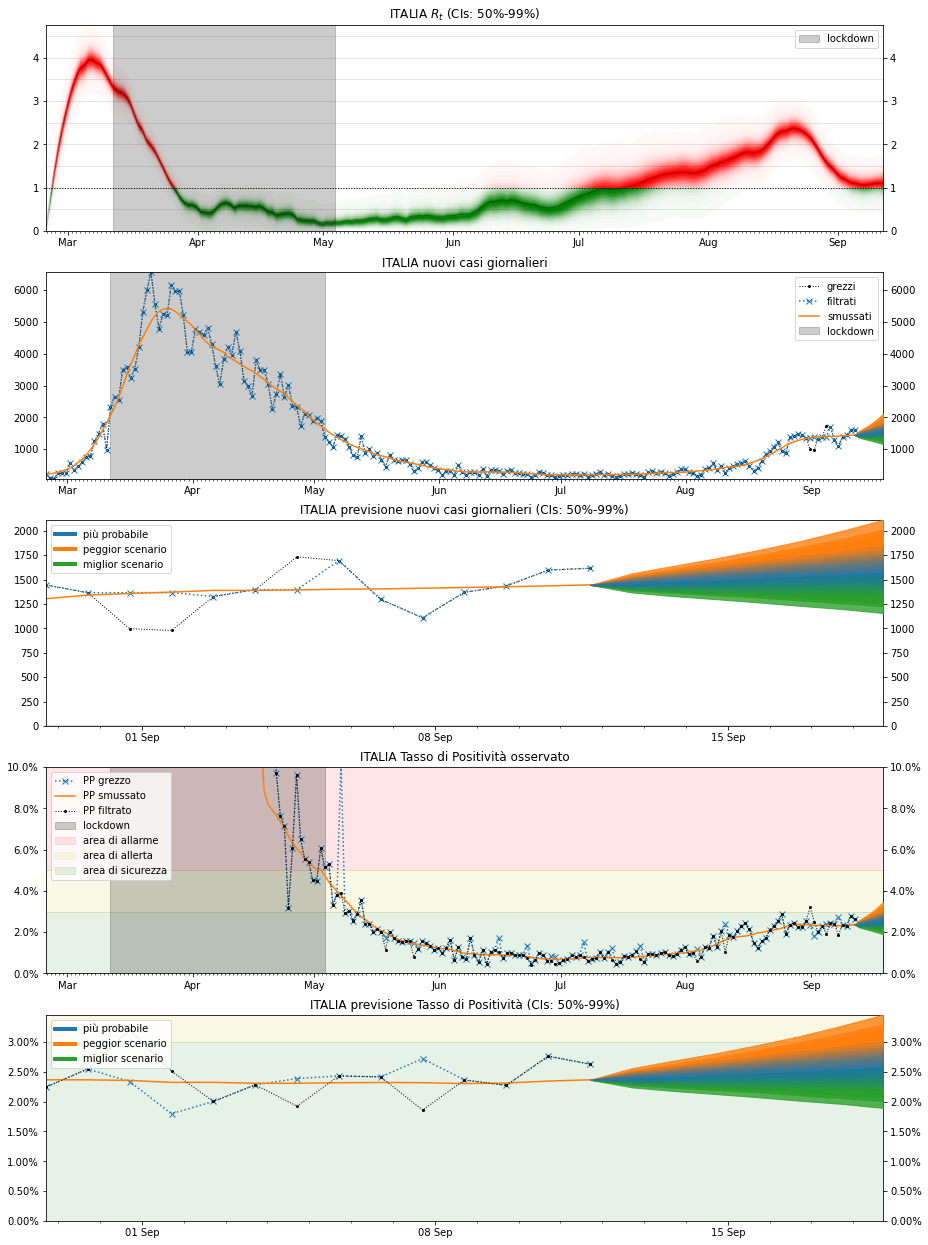

In [16]:
percs = np.linspace(50, 99, 20)

ymax = np.array([])
uppers = np.ndarray(shape=(len(percs), days.size))
lowers = np.ndarray(shape=(len(percs), days.size))

pyjags_data_italy = az.from_pyjags({
    "R": jags_posteriors_italy["R"],
    "y_pred": jags_posteriors_italy["y_pred"],
    "PP": jags_posteriors_italy["PP"],
    "y_pred_hi": jags_posteriors_italy["y_pred_hi"],
    "y_pred_lo": jags_posteriors_italy["y_pred_lo"],
    "PP_lo": jags_posteriors_italy["PP_lo"],
    "PP_hi": jags_posteriors_italy["PP_hi"],
}, warmup_iterations=warmup, save_warmup=False)
summary = az.summary(pyjags_data_italy, var_names="R", kind="stats")
for i, p in enumerate(percs[::-1]):
    upper = np.percentile(pyjags_data_italy.posterior.R, p, axis=1)
    upper = np.mean(upper, axis=0)
    lower = np.percentile(pyjags_data_italy.posterior.R, 100-p, axis=1)
    lower = np.mean(lower, axis=0)
    ymax = np.append(ymax, upper.max())
    uppers[i] = upper
    lowers[i] = lower
pred_means_it = az.summary(pyjags_data_italy, var_names="y_pred", kind="stats")['mean']
PP_pred_means_it = az.summary(pyjags_data_italy, var_names="PP", kind="stats")['mean']
ymax = ymax.max()

        
fig, ax = plt.subplots(5, 1, figsize=(15, 22))

pred_days = pd.date_range(days[-1], days[-1]+pd.Timedelta(days=7), freq="1d")

y_predmax = np.array([])
PP_max = np.array([])
for c, pred in enumerate(['', '_hi', '_lo']):
    y_pred = f"y_pred{pred}"
    PP = f"PP{pred}"
    for i, p in enumerate(percs[::-1]):
        if not pred:
            p -= 4
        y_upper = np.percentile(pyjags_data_italy.posterior[y_pred], p, axis=1)
        y_upper = np.mean(y_upper, axis=0)
        PP_upper = np.percentile(pyjags_data_italy.posterior[PP], p, axis=1)
        PP_upper = np.mean(PP_upper, axis=0)
        
        y_lower = np.percentile(pyjags_data_italy.posterior[y_pred], 100-p, axis=1)
        y_lower = np.mean(y_lower, axis=0)
        PP_lower = np.percentile(pyjags_data_italy.posterior[PP], 100-p, axis=1)
        PP_lower = np.mean(PP_lower, axis=0)
        
        y_predmax = np.append(y_predmax, y_upper.max())
        PP_max = np.append(PP_max, PP_upper.max())
        
        alpha=.8
        if not pred:
            alpha = .1
        if pred == '_lo':
            ax[1].fill_between(pred_days, pred_means_it, y_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[2].fill_between(pred_days, pred_means_it, y_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[3].fill_between(pred_days, PP_pred_means_it, PP_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[4].fill_between(pred_days, PP_pred_means_it, PP_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
        elif pred == '_hi':
            ax[1].fill_between(pred_days, pred_means_it, y_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[2].fill_between(pred_days, pred_means_it, y_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[3].fill_between(pred_days, PP_pred_means_it, PP_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[4].fill_between(pred_days, PP_pred_means_it, PP_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
        else:
            ax[1].fill_between(pred_days, y_lower, y_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[2].fill_between(pred_days, y_lower, y_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[3].fill_between(pred_days, PP_upper, PP_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
            ax[4].fill_between(pred_days, PP_upper, PP_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
        
y_predmax = y_predmax.max()
PP_max = PP_max.max()
ax[1].fill_betweenx(
    [0,it['nuovi_positivi'].max()*2],
    days[days>=pd.to_datetime("2020-03-11")][0],
    days[days<=pd.to_datetime("2020-05-04")][-1],
    color="k", alpha=.2, label="lockdown"
)
ax[1].plot(days, it['nuovi_positivi'], 'ok:', lw=1, ms=2, label="grezzi")
ax[1].plot(days, pos_it_flt.values, 'x:', label="filtrati")
ax[1].plot(days, pos_it_smt.values, label="smussati")
ax[1].axhline(0, c="k", alpha=.2)
ax[1].set_xlim(days[0], days[-1]+pd.Timedelta(days=7))
ax[1].set_ylim(it['nuovi_positivi'].min(), it['nuovi_positivi'].max())
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(labelright=True)
ax[1].legend()
ax[1].set_title(f"ITALIA nuovi casi giornalieri")

ax[2].set_ylim(0, y_predmax)
ax[2].plot(days, it['nuovi_positivi'], 'ok:', lw=1, ms=2, label="grezzi")
ax[2].plot(days, pos_it_flt.values, 'x:', label="filtrati")
ax[2].plot(days, pos_it_smt.values, label="smussati")
ax[2].axhline(0, c="k", alpha=.2)
ax[2].set_xlim(days[-prediction*2], days[-1]+pd.Timedelta(days=7))
ax[2].yaxis.set_ticks_position('both')
ax[2].tick_params(labelright=True)
custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4),
                Line2D([0], [0], color="C2", lw=4)]
ax[2].legend(
    custom_lines, ['più probabile', 'peggior scenario', 'miglior scenario'],
    loc="upper left"
)
ax[2].set_title(f"ITALIA previsione nuovi casi giornalieri (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

PP_days = [days[0], pred_days[-1]]
ax[3].fill_betweenx(
    [0,100],
    days[days>=pd.to_datetime("2020-03-11")][0],
    days[days<=pd.to_datetime("2020-05-04")][-1],
    color="k", alpha=.2, label="lockdown"
)
ax[3].fill_between(PP_days, 5, 100, color="r", alpha=.1, label="area di allarme", zorder=0)
ax[3].fill_between(PP_days, 3, 5, color="y", alpha=.1, label="area di allerta", zorder=0)
ax[3].fill_between(PP_days, 0, 3, color="g", alpha=.1, label="area di sicurezza", zorder=0)
ax[3].plot(days[1:], PP_raw, 'x:', label="PP grezzo")
ax[3].plot(days[1:], PP_smt, label="PP smussato")
ax[3].plot(days[1:], PP_flt, 'ok:', lw=1, ms=2, label="PP filtrato")
#ax[3].axhline(5, c="k", zorder=200)
#ax[3].axhline(3, c="k", ls="--", lw=1, zorder=200)
ax[3].set_xlim(days[0], pred_days[-1])
ax[3].set_ylim(0, 10)
ax[3].yaxis.set_ticks_position('both')
ax[3].tick_params(labelright=True)
ax[3].yaxis.set_major_formatter(ticker.PercentFormatter())
ax[3].legend(loc="upper left")
ax[3].set_title(f"ITALIA Tasso di Positività osservato")

ax[4].set_ylim(0, PP_max)
ax[4].plot(days[1:], PP_raw, 'x:', label="PP grezzo")
ax[4].plot(days[1:], PP_smt, label="PP smussato")
ax[4].plot(days[1:], PP_flt, 'ok:', lw=1, ms=2, label="PP filtrato")
ax[4].fill_between(PP_days, 5, 100, color="r", alpha=.1, label="area di allarme", zorder=0)
ax[4].fill_between(PP_days, 3, 5, color="y", alpha=.1, label="area di allerta", zorder=0)
ax[4].fill_between(PP_days, 0, 3, color="g", alpha=.1, label="area di sicurezza", zorder=0)
#ax[4].axhline(5, c="k", zorder=200)
#ax[4].axhline(3, c="k", ls="--", lw=1, zorder=200)
ax[4].set_xlim(days[-prediction*2], days[-1]+pd.Timedelta(days=7))
ax[4].yaxis.set_ticks_position('both')
ax[4].yaxis.set_major_formatter(ticker.PercentFormatter())
ax[4].tick_params(labelright=True)
custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4),
                Line2D([0], [0], color="C2", lw=4)]
ax[4].legend(
    custom_lines, ['più probabile', 'peggior scenario', 'miglior scenario'],
    loc="upper left"
)
ax[4].set_title(f"ITALIA previsione Tasso di Positività (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")


steps = .4/(len(percs)-1)
for i, (upper, lower) in enumerate(zip(uppers, lowers)):
    alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
    ax[0].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
    ax[0].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

ax[0].fill_betweenx(
    [0,100],
    days[days>=pd.to_datetime("2020-03-11")][0],
    days[days<=pd.to_datetime("2020-05-04")][-1],
    color="k", alpha=.2, label="lockdown"
)
    
ax[0].plot(days, summary["mean"], c="k", alpha=.25)

ax[0].hlines(np.arange(0, 12, .5), days[0], days[-1], color="k", lw=1, alpha=.1)
ax[0].axhline(1, c="k", ls=":", lw=1)

ax[0].fill_between(days, 1, 12, color="red", zorder=0) #, alpha=.2)
ax[0].fill_between(days, 0, 1, color="green", zorder=0) #, alpha=.2)

ax[0].set_xlim(days[0], days[-1])

ax[0].set_title(fr"ITALIA $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

ax[0].set_ylim(0, ymax)
ax[0].yaxis.set_ticks_position('both')
ax[0].tick_params(labelright=True)
ax[0].legend()

for w in [2,4]:
    ax[w].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[w].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax[w].xaxis.set_minor_locator(mdates.DayLocator())
for w in [0,1,3]:
    ax[w].xaxis.set_major_locator(mdates.MonthLocator())
    ax[w].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[w].xaxis.set_minor_locator(mdates.DayLocator())

plt.show()
plt.close(fig="all")

***

# Abruzzo

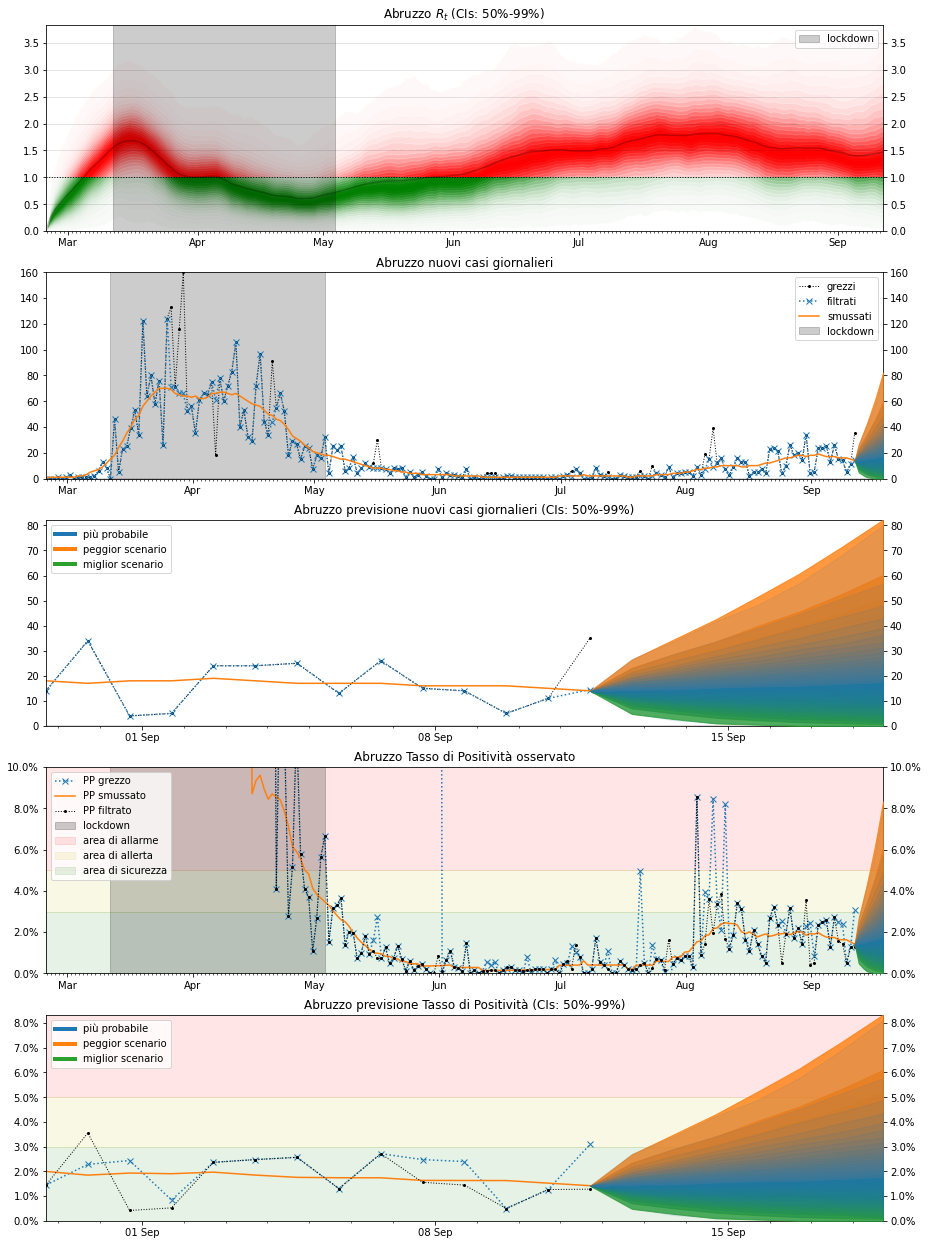

***

# Basilicata

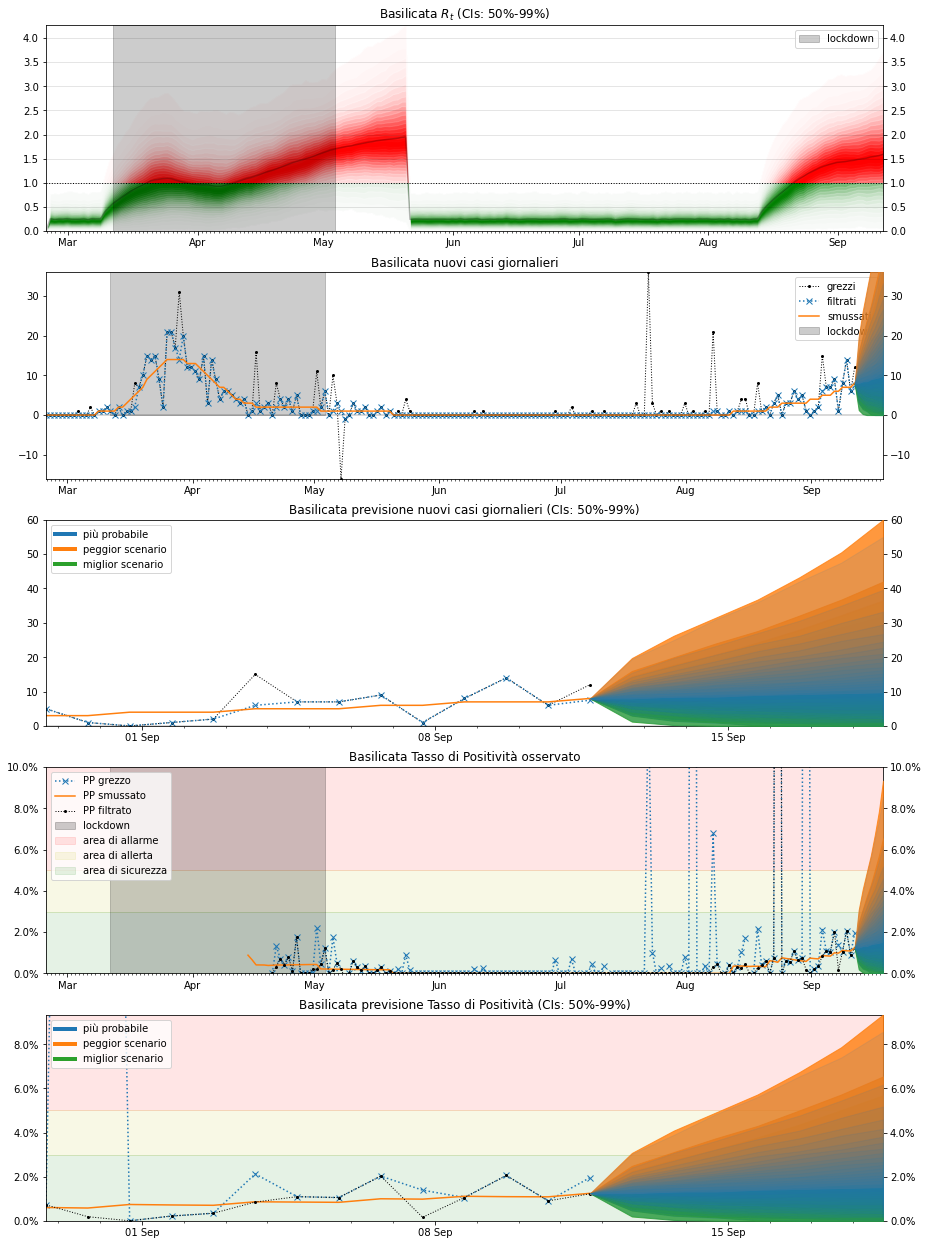

***

# Calabria

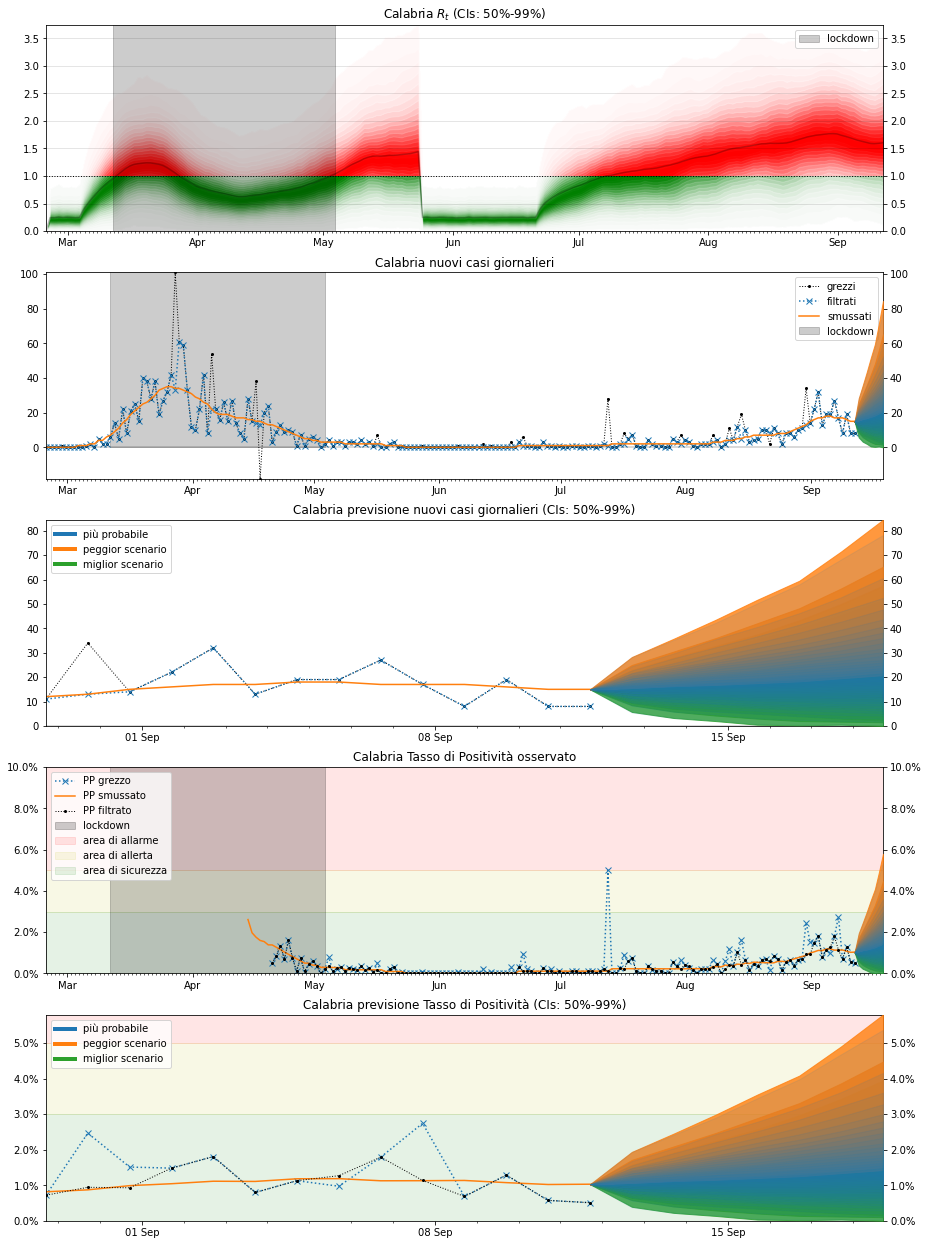

***

# Campania

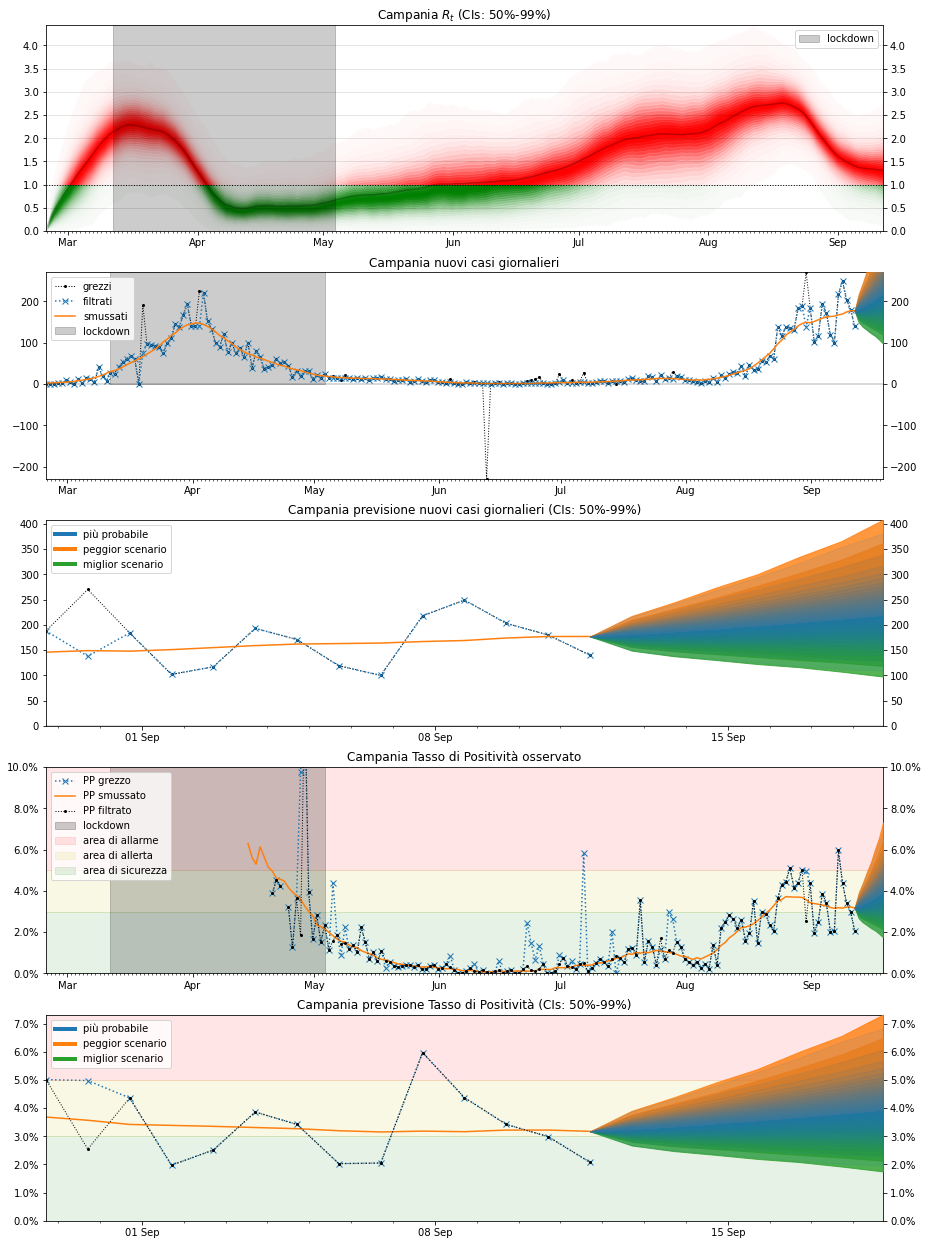

***

# Emilia-Romagna

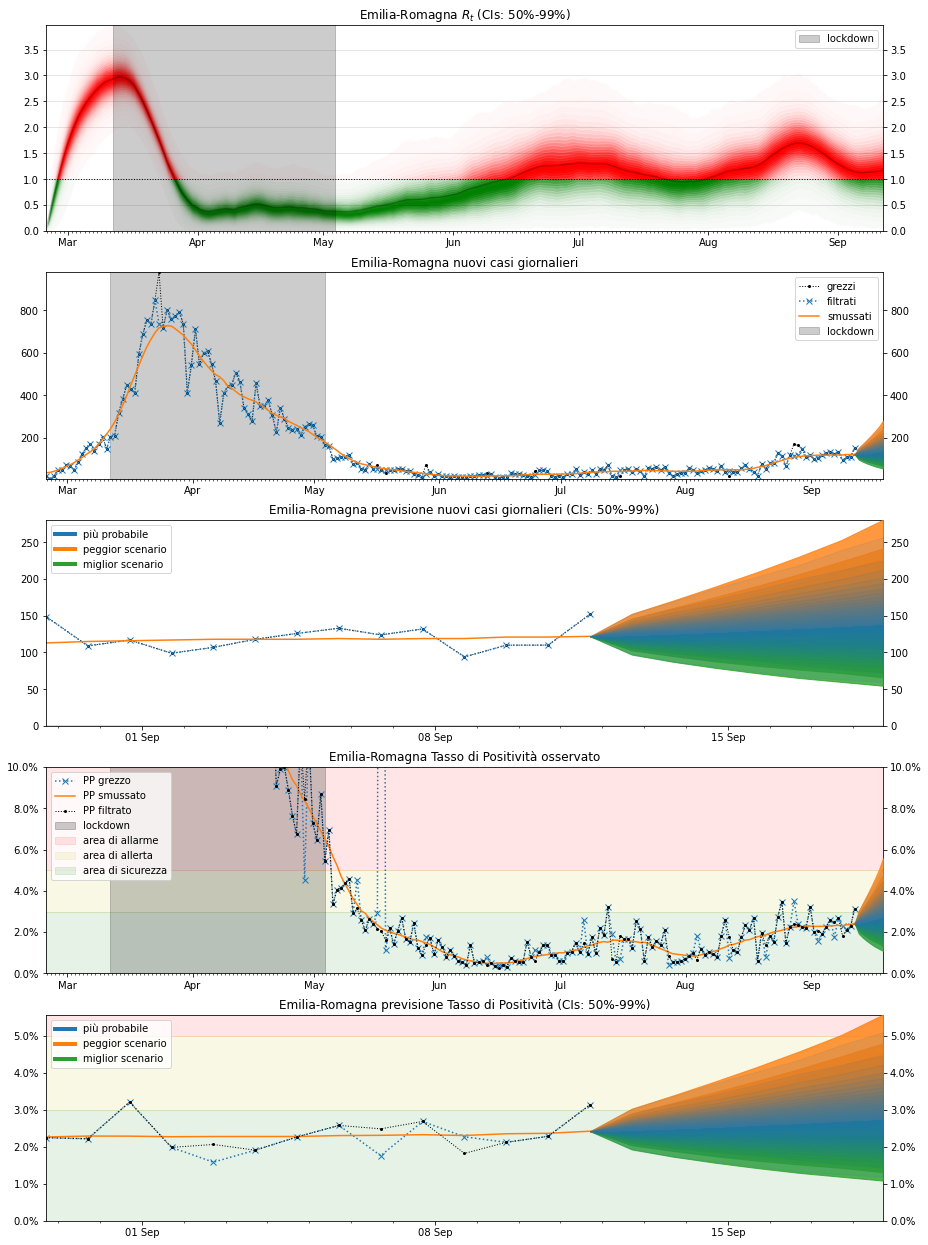

***

# Friuli Venezia Giulia

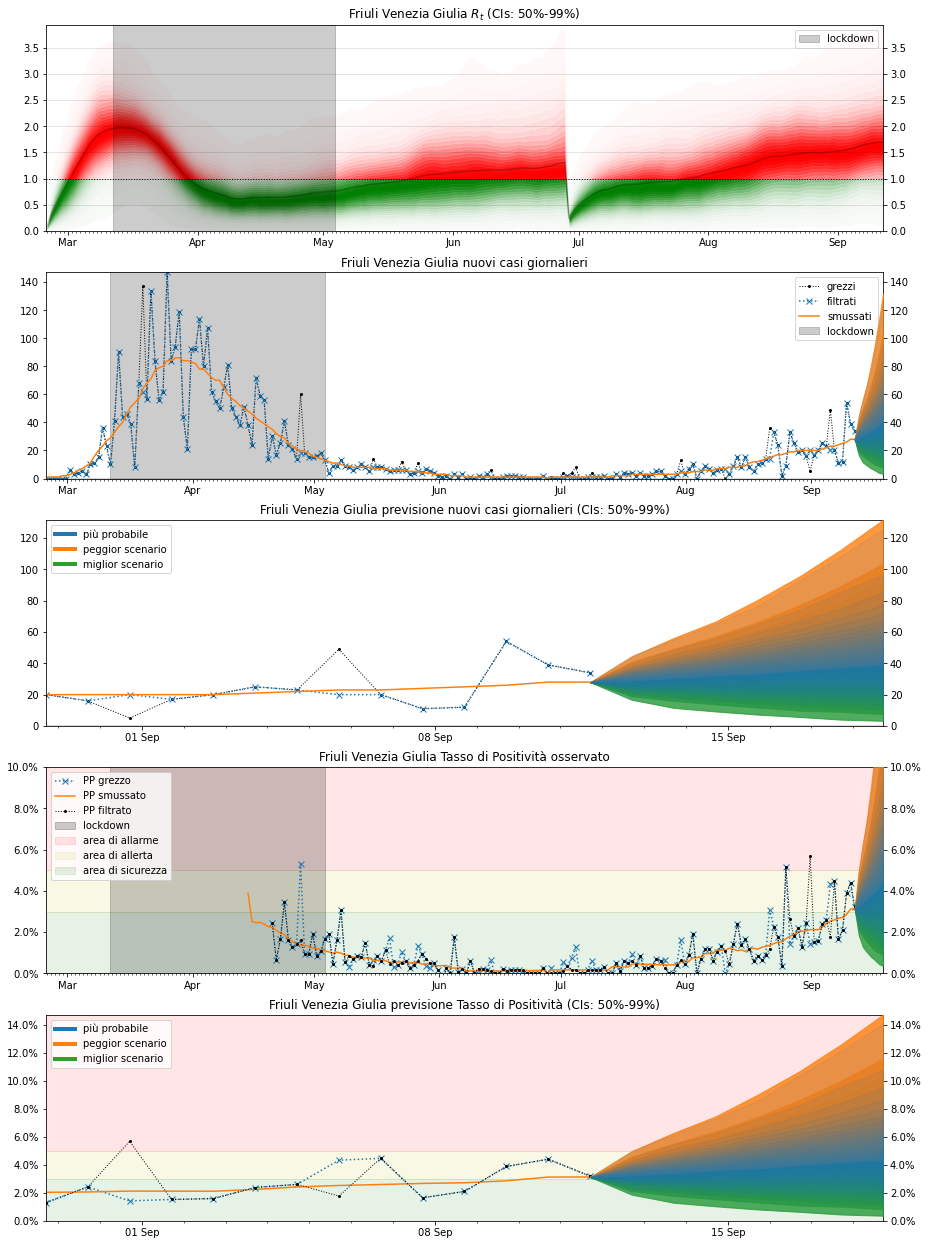

***

# Lazio

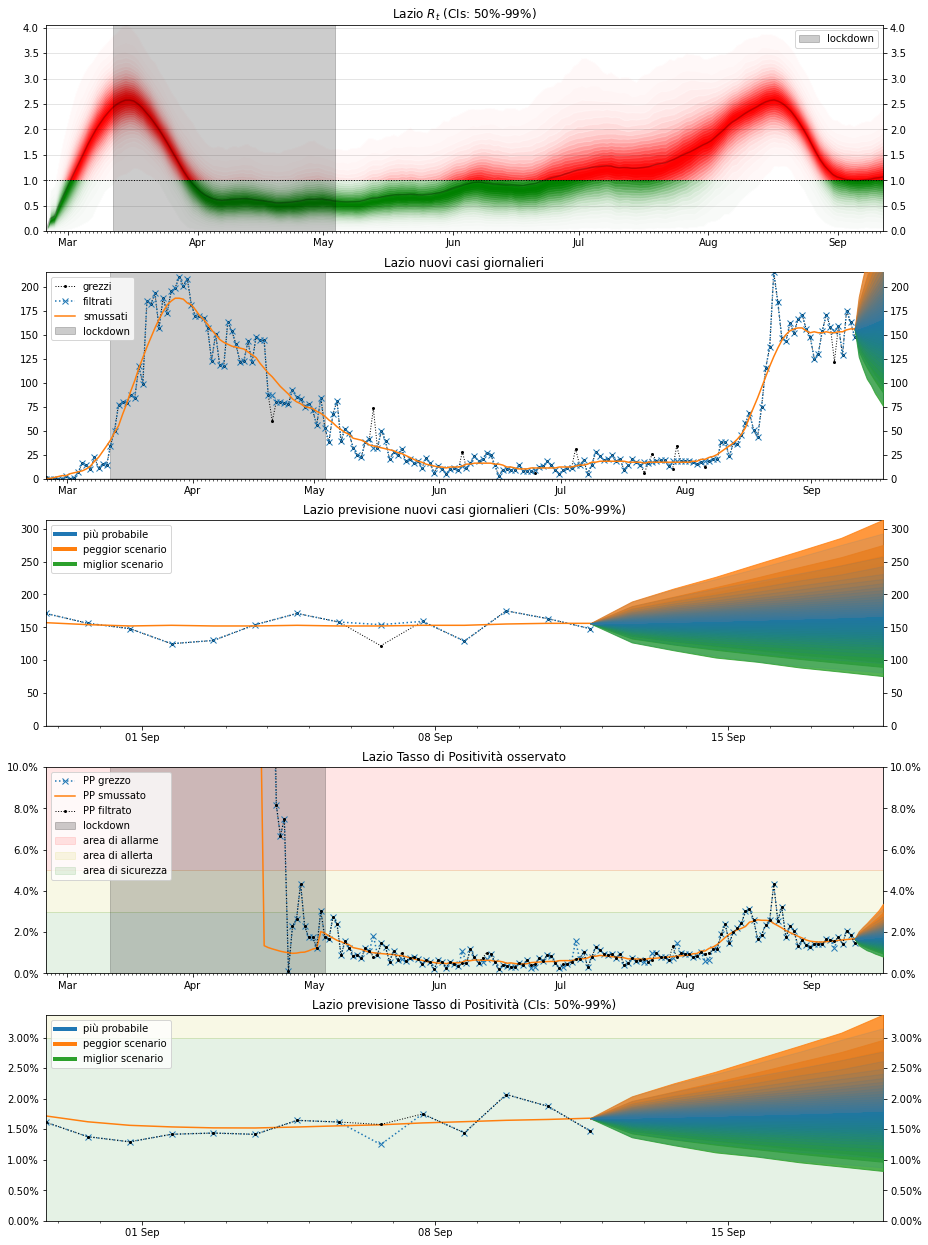

***

# Liguria

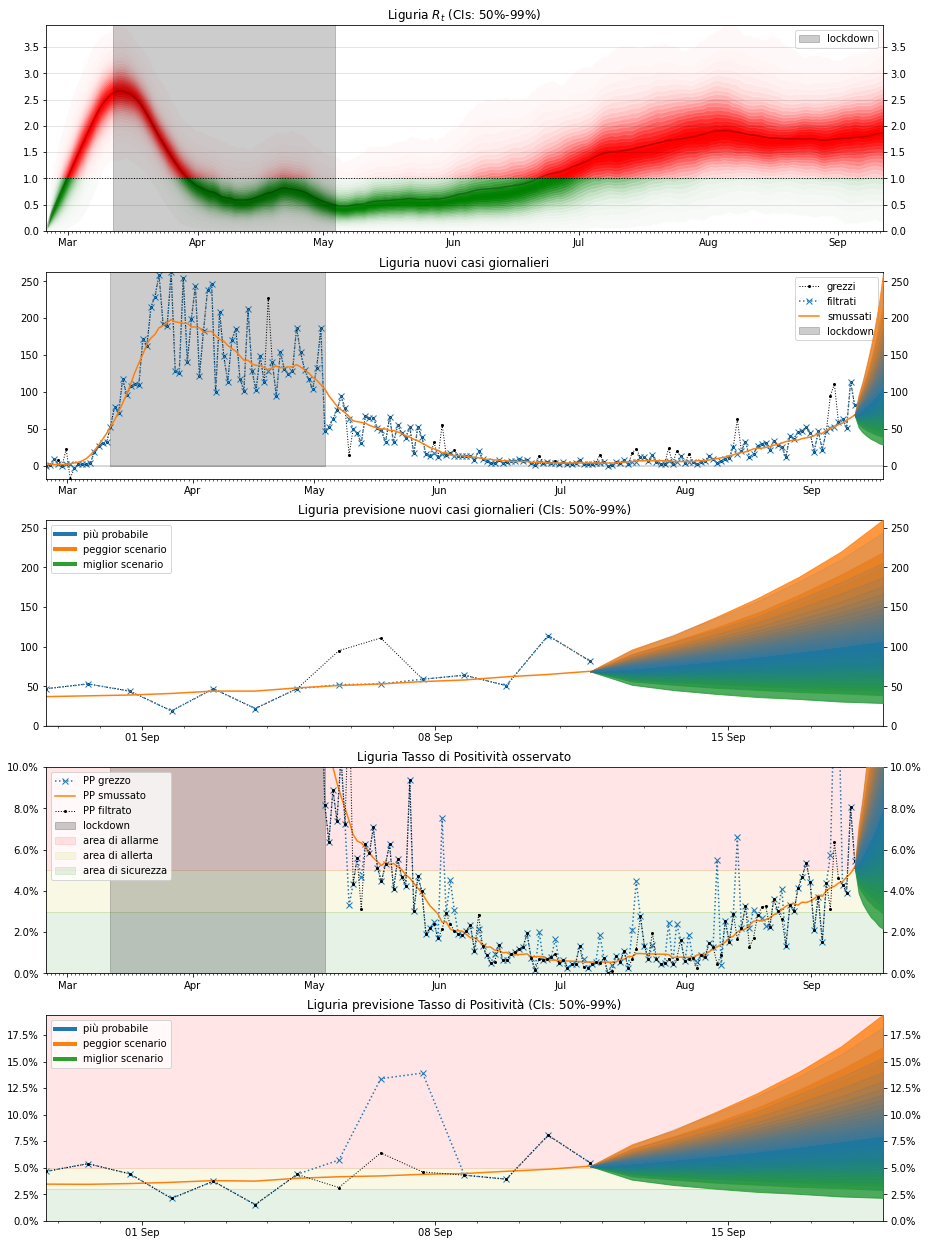

***

# Lombardia

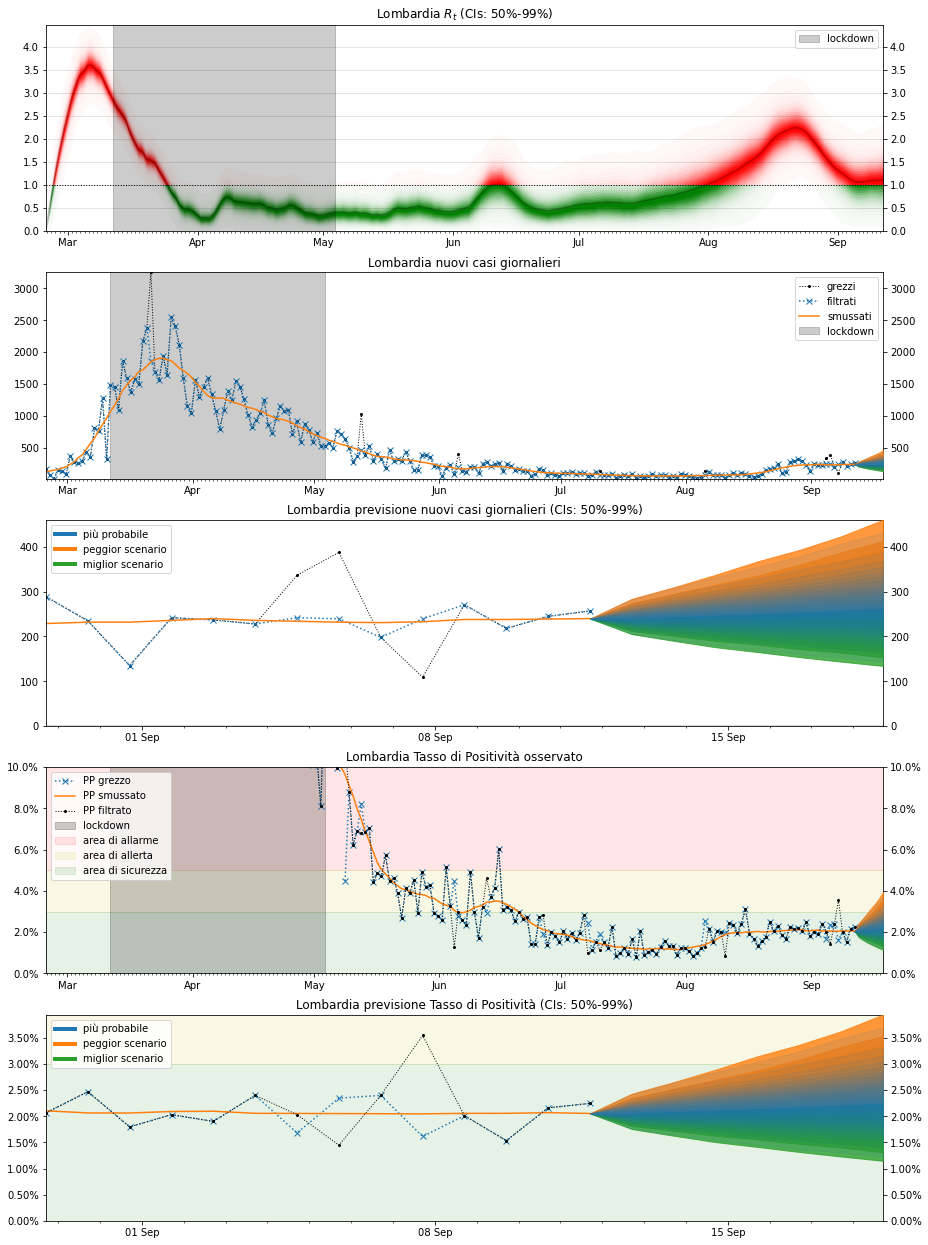

***

# Marche

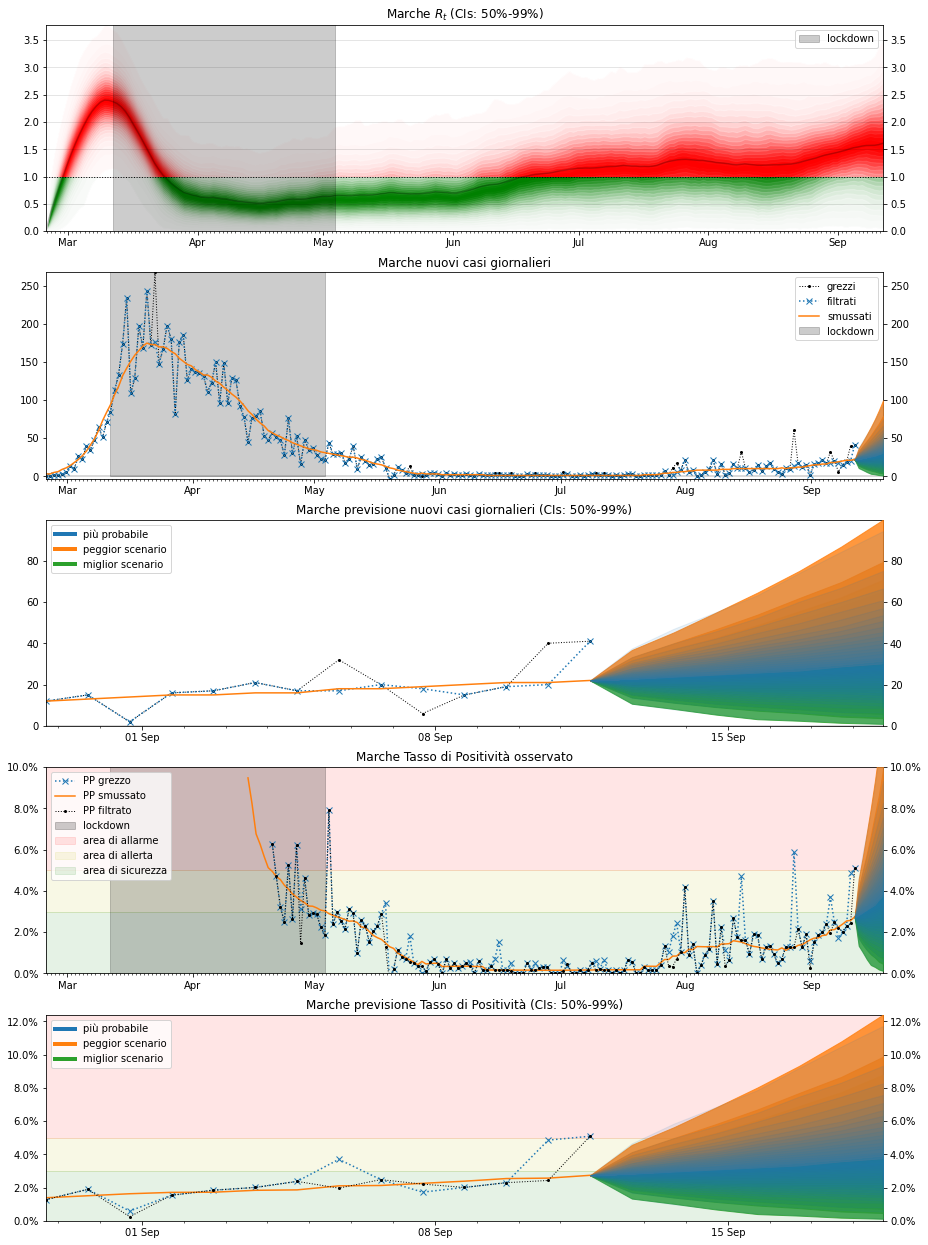

***

# Molise

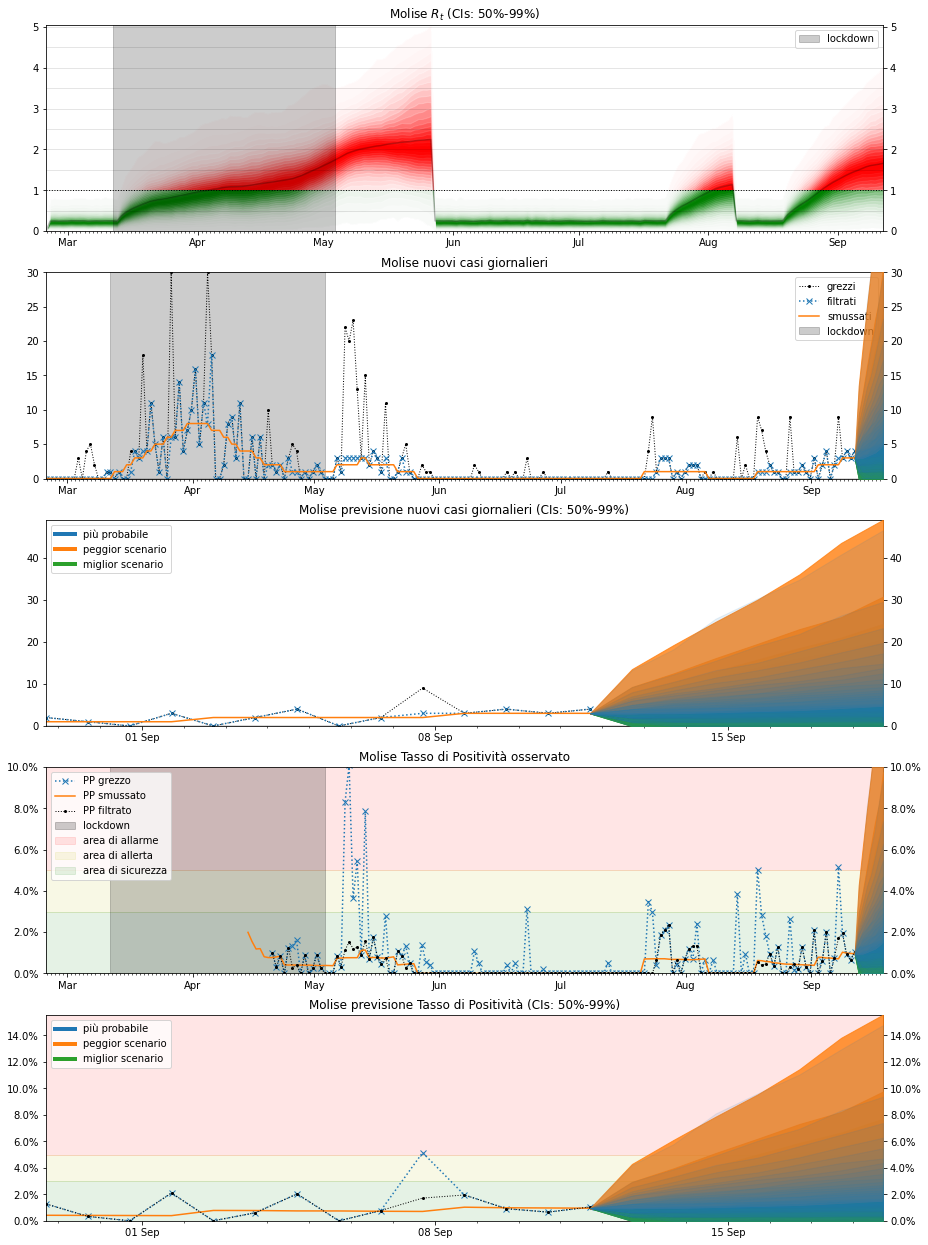

***

# P.A. Bolzano

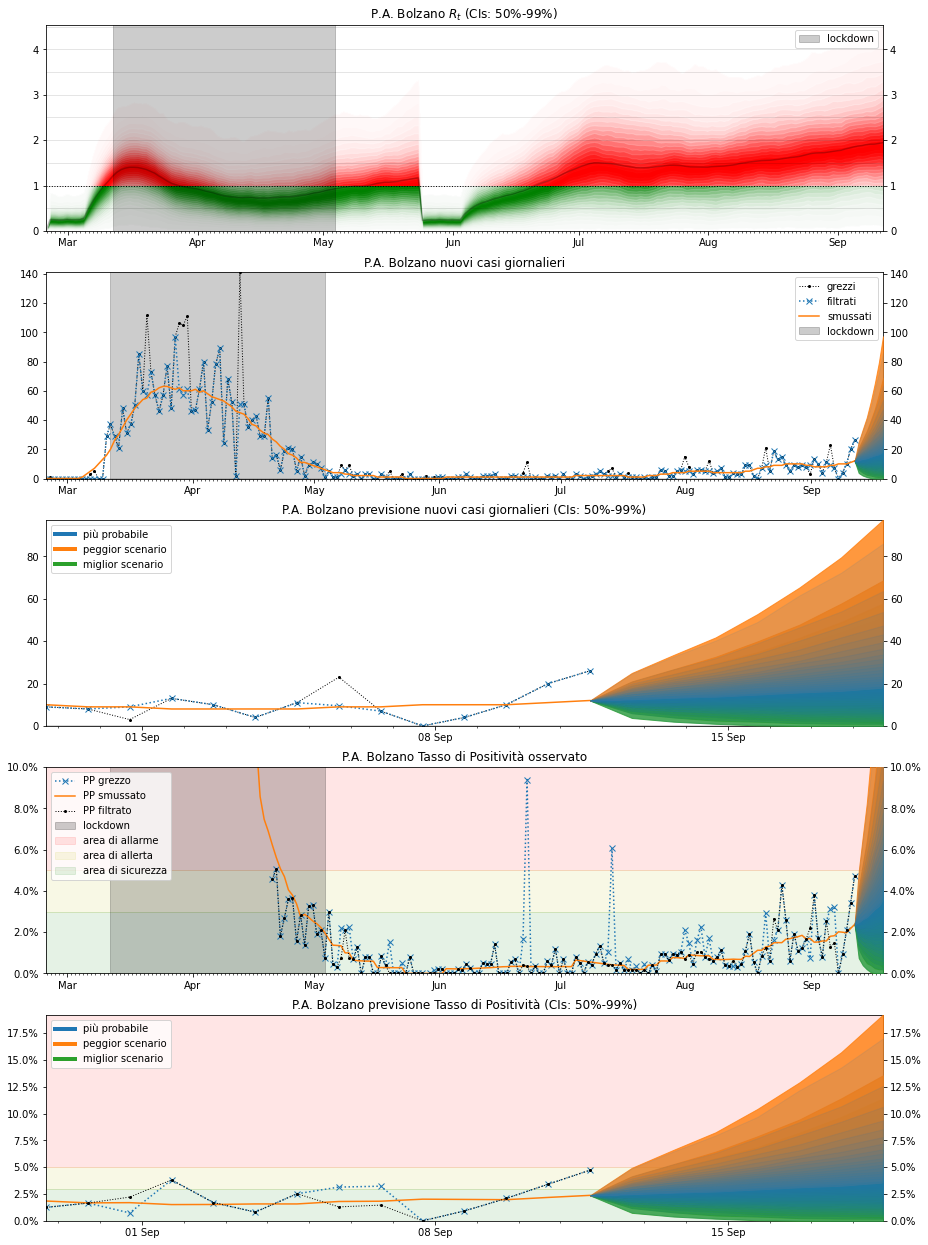

***

# P.A. Trento

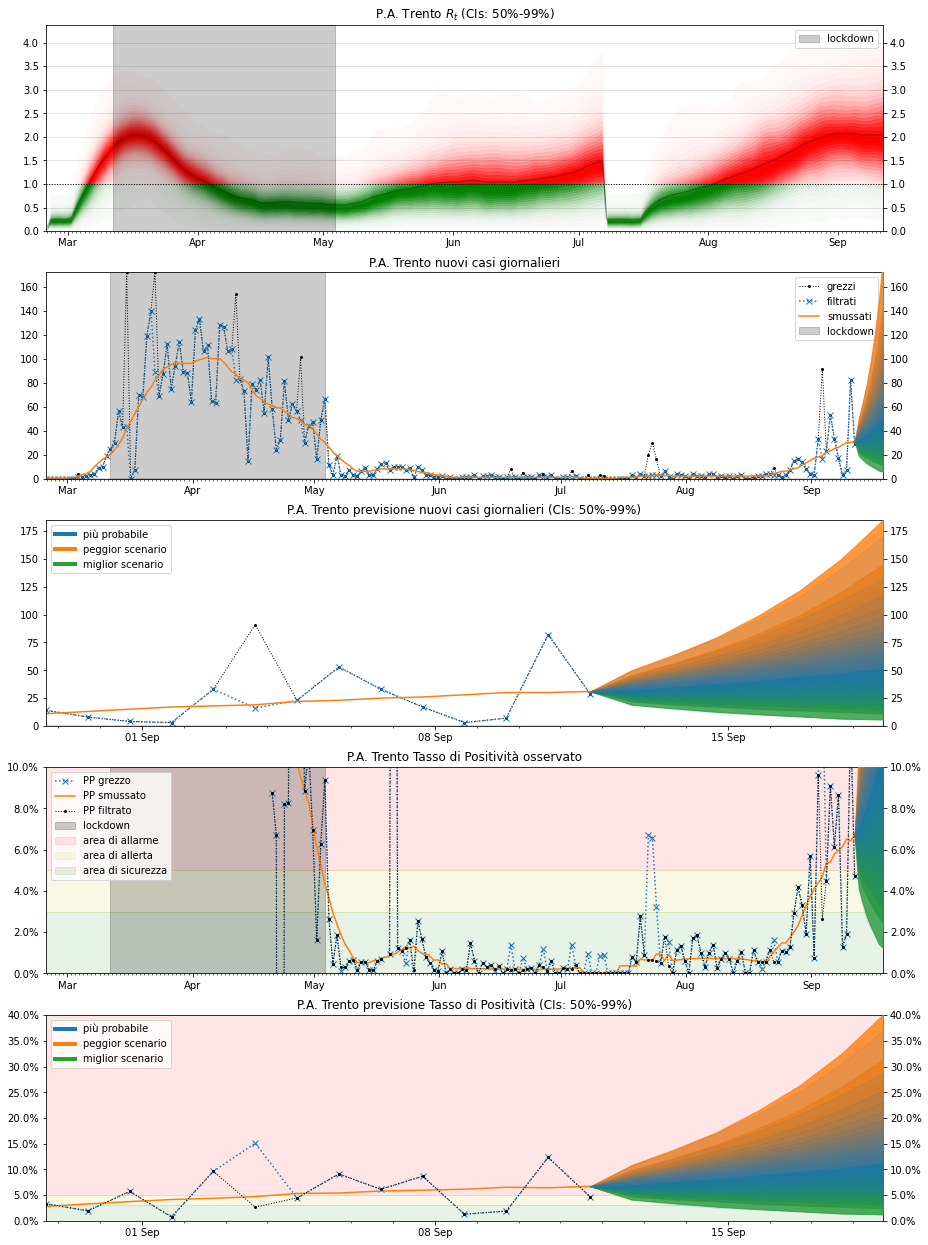

***

# Piemonte

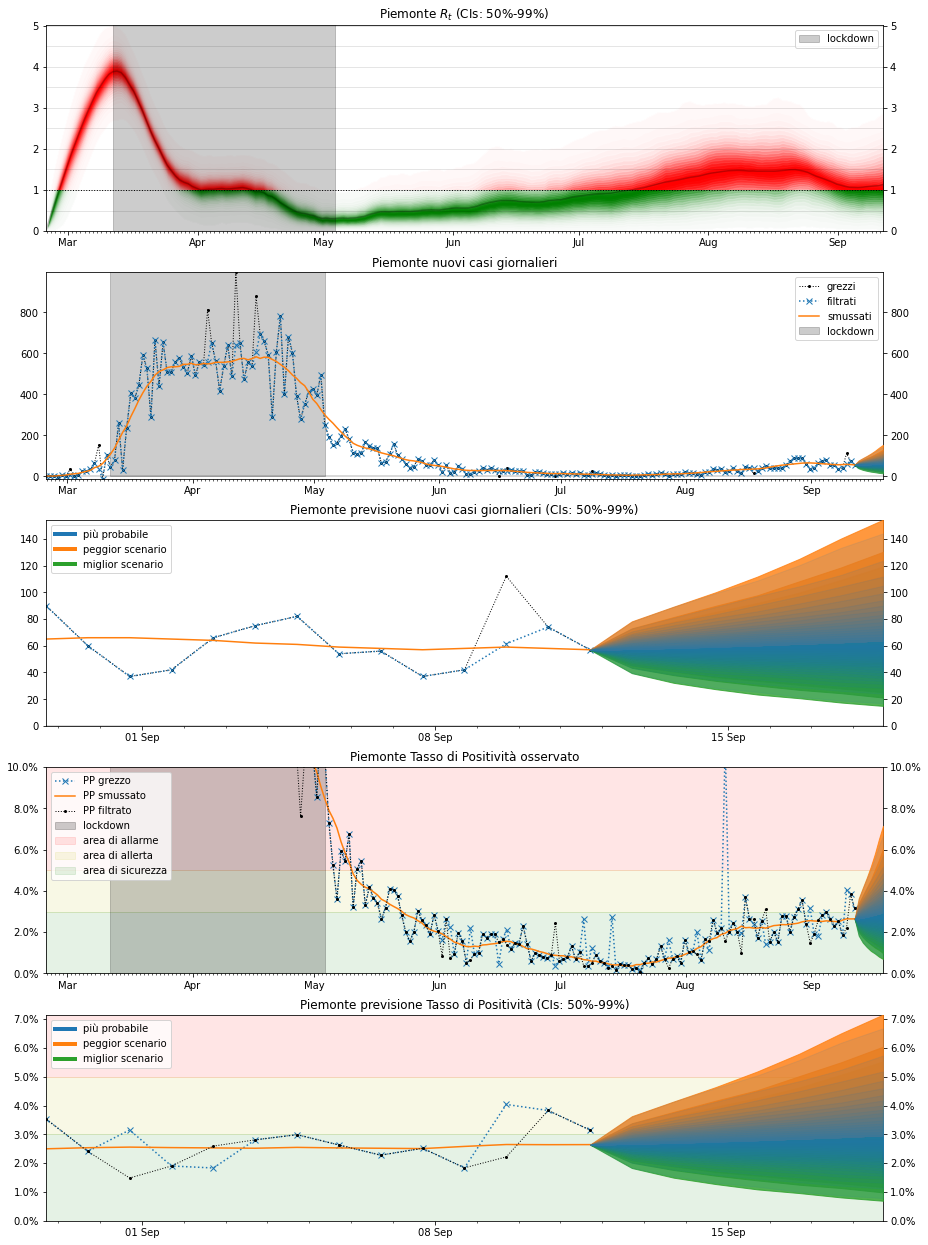

***

# Puglia

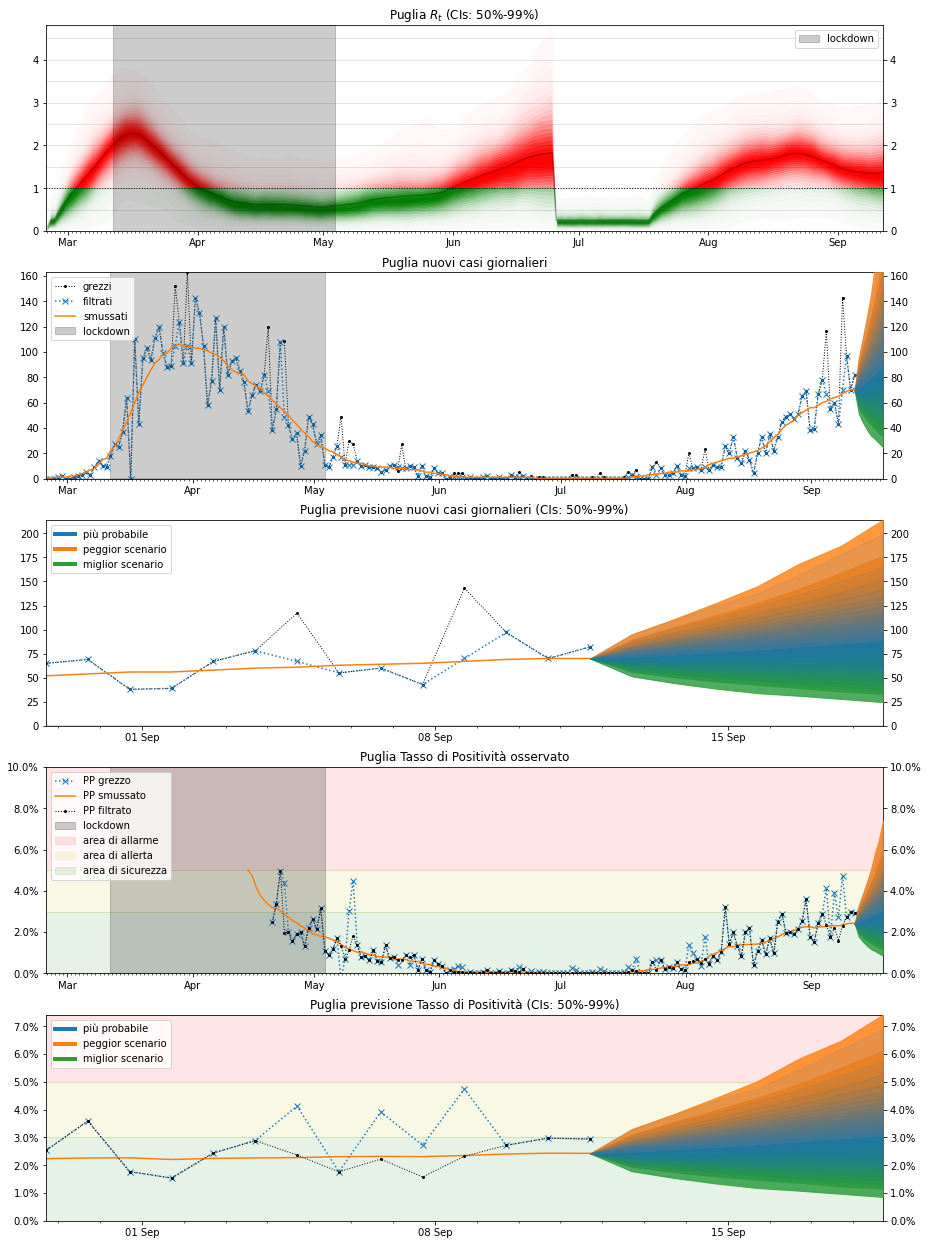

***

# Sardegna

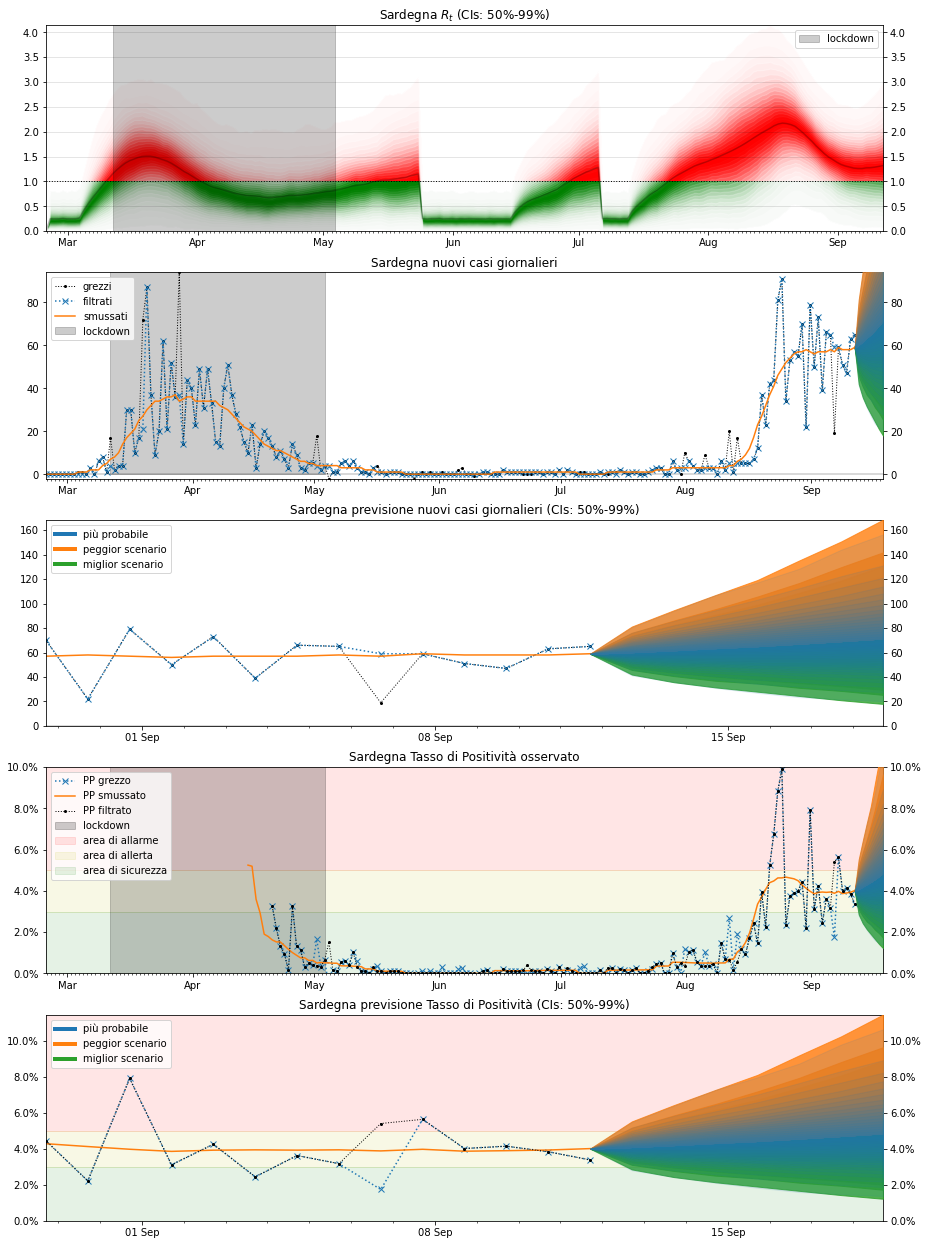

***

# Sicilia

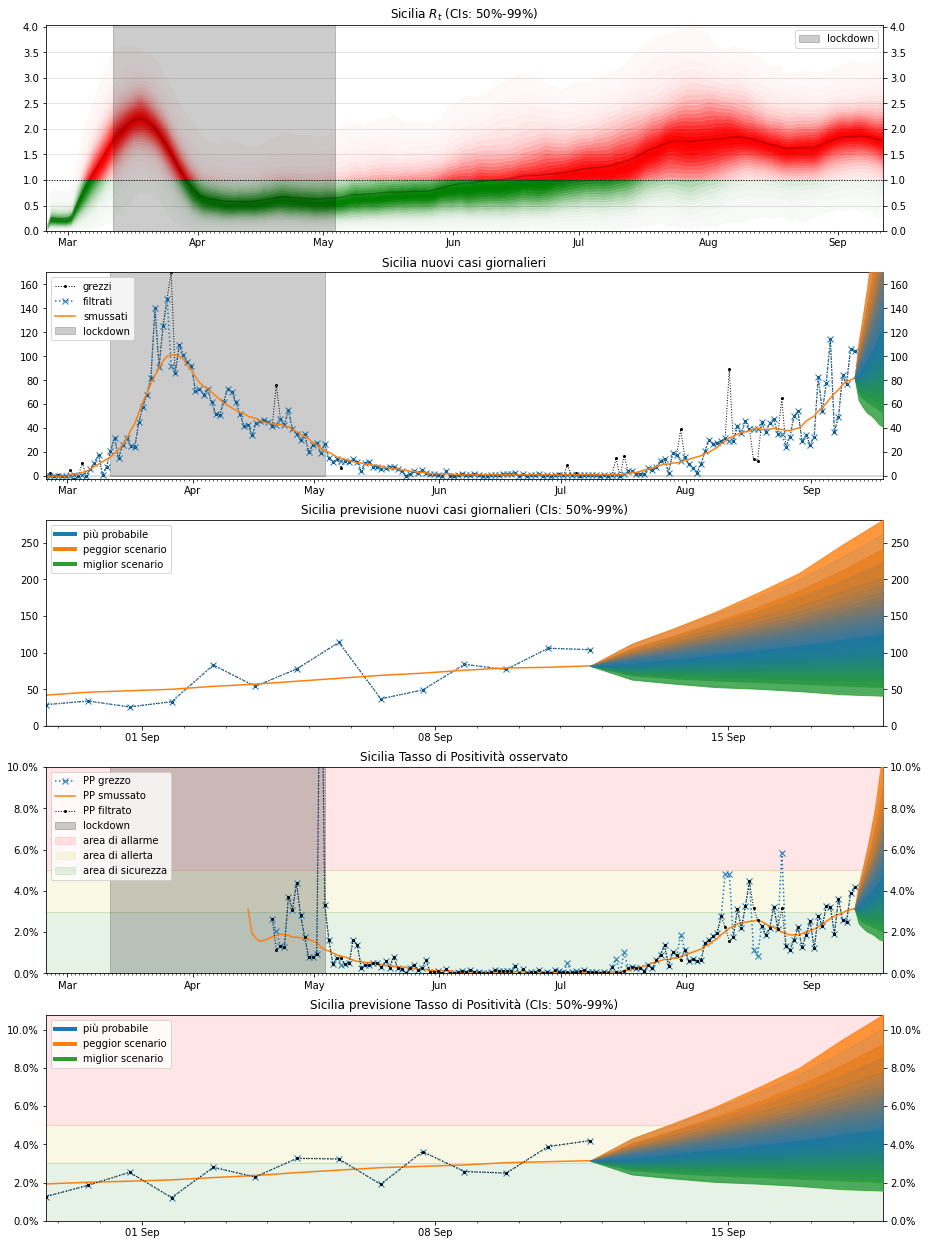

***

# Toscana

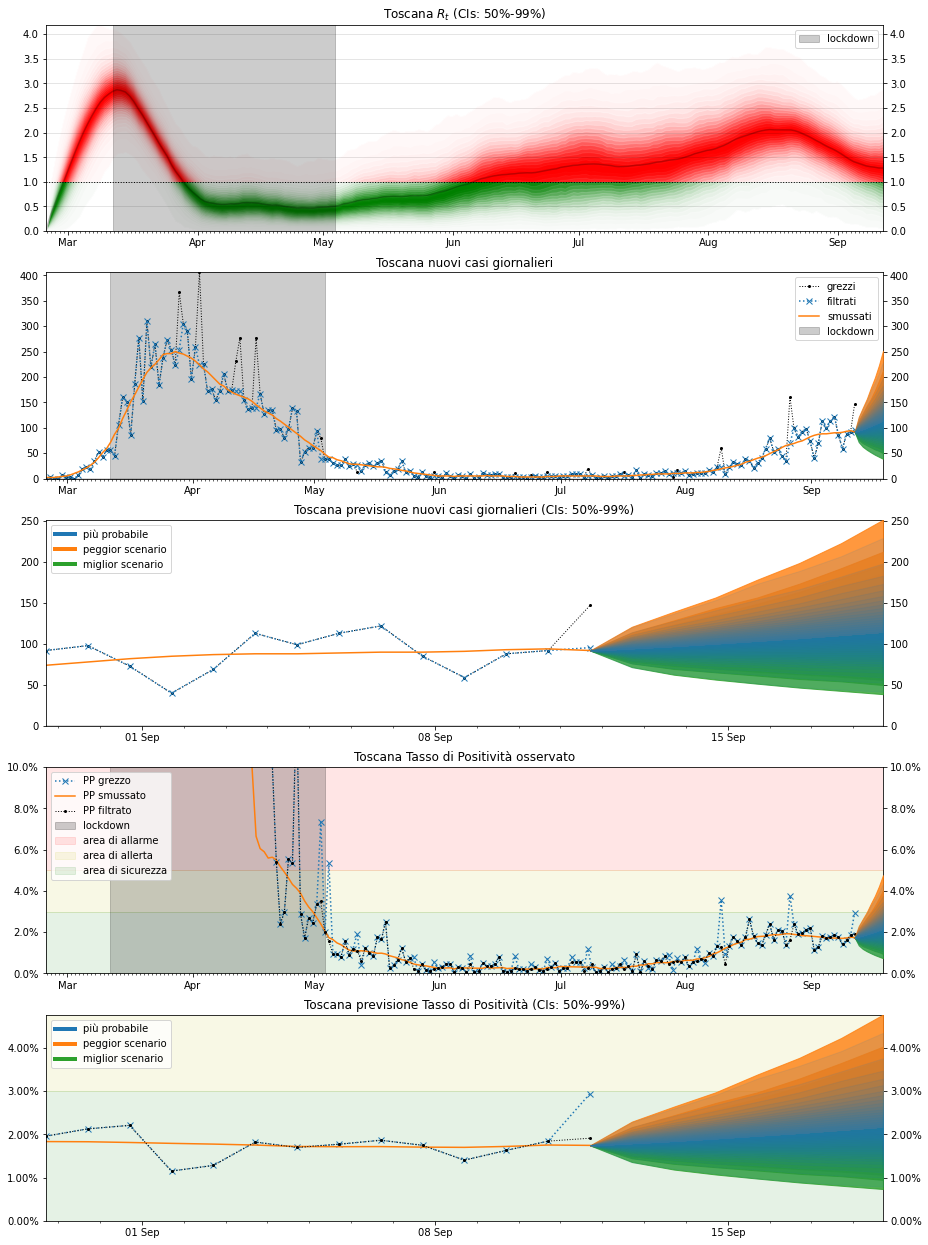

***

# Umbria

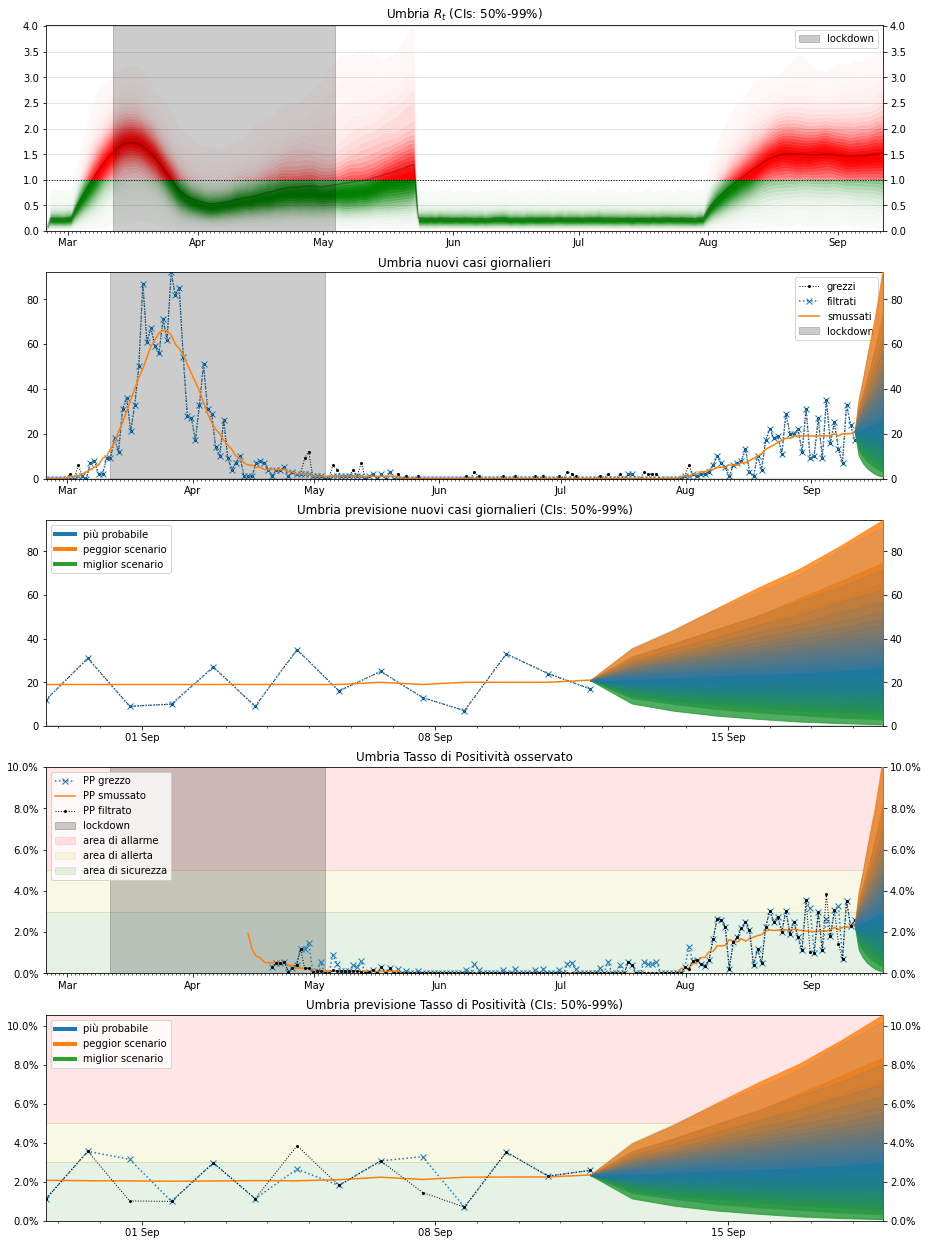

***

# Valle d'Aosta

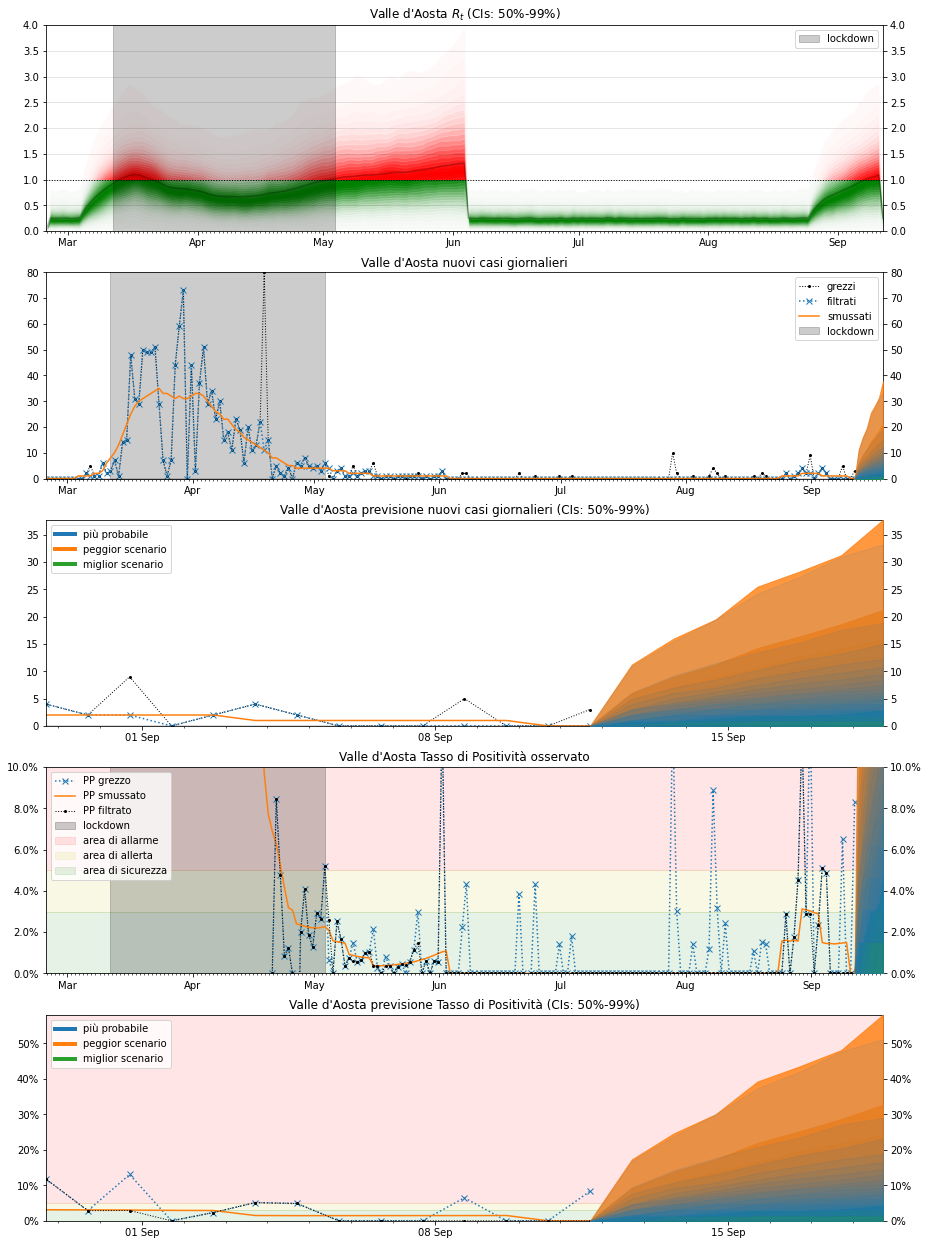

***

# Veneto

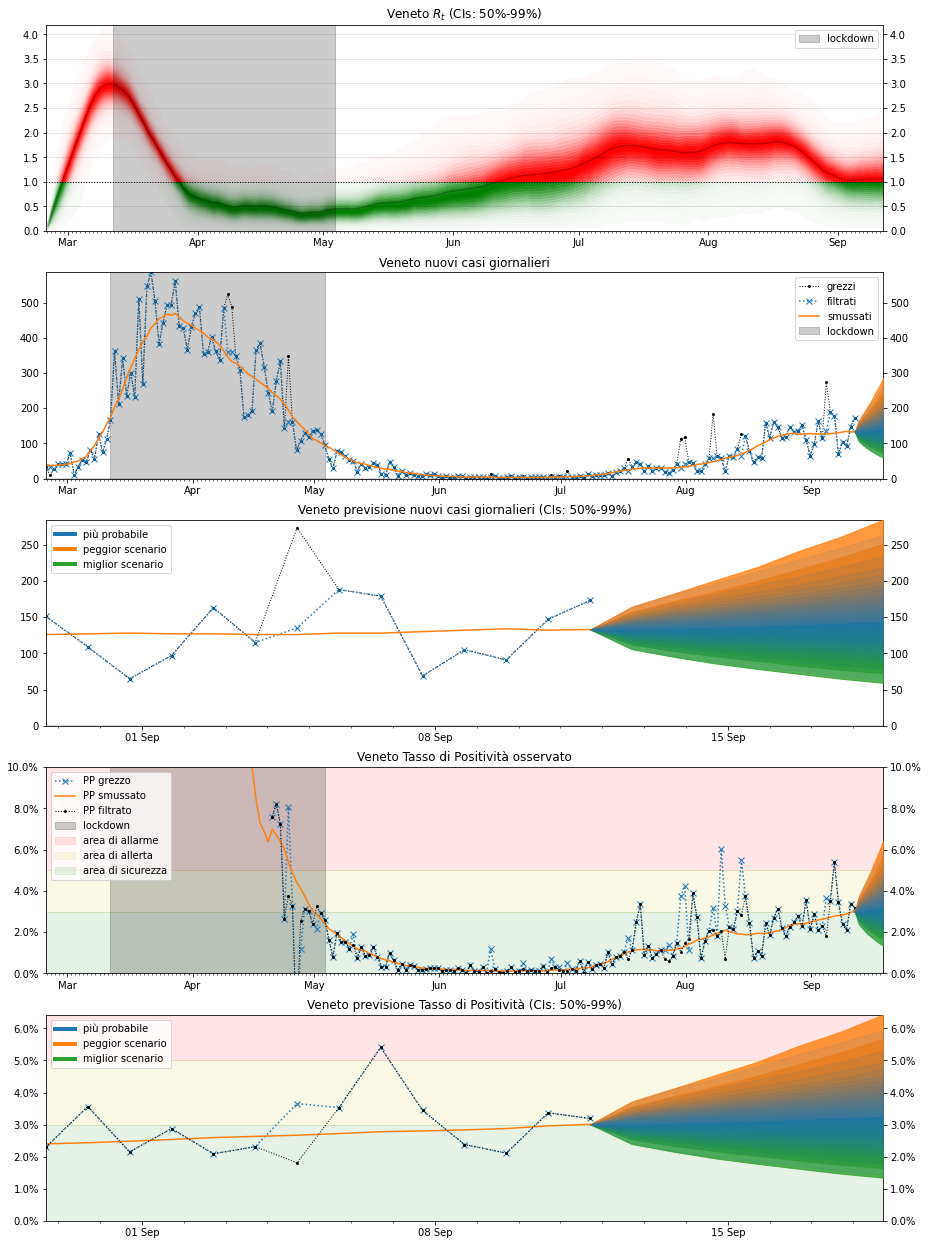

***

In [17]:
percs = np.linspace(50, 99, 20)

if not jags_posteriors_italy:
    with open("posterior_samples_italy.pkl", "rb") as f:
        jags_posteriors_italy = pickle.load(f)

        
uppers = np.ndarray(shape=(countries.size, len(percs), days.size))
lowers = np.ndarray(shape=(countries.size, len(percs), days.size))
means = np.ndarray(shape=(countries.size, days.size))
pred_means = np.ndarray(shape=(countries.size, prediction+1))
PP_pred_means = np.ndarray(shape=(countries.size, prediction+1))
    
for r, region in enumerate(countries):
    display(Markdown(f"# {region}"))
    
    ymax = np.array([])

    pyjags_data_region = az.from_pyjags({
        "R": jags_posteriors_italy["RR"][r],
        "y_pred": jags_posteriors_italy["yR_pred"][r],
        "PP": jags_posteriors_italy["PPR"][r],
        "y_pred_hi": jags_posteriors_italy["yR_pred_hi"][r],
        "y_pred_lo": jags_posteriors_italy["yR_pred_lo"][r],
        "PP_lo": jags_posteriors_italy["PPR_lo"][r],
        "PP_hi": jags_posteriors_italy["PPR_hi"][r],
    }, warmup_iterations=warmup, save_warmup=False)
    summary = az.summary(pyjags_data_region, var_names="R", kind="stats")
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(pyjags_data_region.posterior.R, p, axis=1)
        upper = np.mean(upper, axis=0)
        lower = np.percentile(pyjags_data_region.posterior.R, 100-p, axis=1)
        lower = np.mean(lower, axis=0)
        ymax = np.append(ymax, upper.max())
        uppers[r,i] = upper
        lowers[r,i] = lower
    means[r] = summary["mean"]
    pred_means[r] = az.summary(pyjags_data_region, var_names="y_pred", kind="stats")['mean']
    PP_pred_means[r] = az.summary(pyjags_data_region, var_names="PP", kind="stats")['mean']
    ymax = ymax.max()


    fig, ax = plt.subplots(5, 1, figsize=(15, 22))

    pred_days = pd.date_range(days[-1], days[-1]+pd.Timedelta(days=7), freq="1d")

    y_predmax = np.array([])
    PP_max = np.array([])

    for c, pred in enumerate(['', '_hi', '_lo']):
        y_pred = f"y_pred{pred}"
        PP = f"PP{pred}"
        for i, p in enumerate(percs[::-1]):
            y_upper = np.percentile(pyjags_data_region.posterior[y_pred], p, axis=1)
            y_upper = np.mean(y_upper, axis=0)
            PP_upper = np.percentile(pyjags_data_region.posterior[PP], p, axis=1)
            PP_upper = np.mean(PP_upper, axis=0)

            y_lower = np.percentile(pyjags_data_region.posterior[y_pred], 100-p, axis=1)
            y_lower = np.mean(y_lower, axis=0)
            PP_lower = np.percentile(pyjags_data_region.posterior[PP], 100-p, axis=1)
            PP_lower = np.mean(PP_lower, axis=0)

            y_predmax = np.append(y_predmax, y_upper.max())
            PP_max = np.append(PP_max, PP_upper.max())

            alpha=.8
            if not pred:
                alpha = .1
            if pred == '_lo':
                ax[1].fill_between(pred_days, pred_means[r], y_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[2].fill_between(pred_days, pred_means[r], y_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[3].fill_between(pred_days, PP_pred_means[r], PP_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[4].fill_between(pred_days, PP_pred_means[r], PP_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
            elif pred == '_hi':
                ax[1].fill_between(pred_days, pred_means[r], y_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[2].fill_between(pred_days, pred_means[r], y_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[3].fill_between(pred_days, PP_pred_means[r], PP_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[4].fill_between(pred_days, PP_pred_means[r], PP_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
            else:
                ax[1].fill_between(pred_days, y_lower, y_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[2].fill_between(pred_days, y_lower, y_upper, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[3].fill_between(pred_days, PP_upper, PP_lower, color=f"C{c}", alpha=alpha, zorder=100-c)
                ax[4].fill_between(pred_days, PP_upper, PP_lower, color=f"C{c}", alpha=alpha, zorder=100-c)

    y_predmax = y_predmax.max()
    PP_max = PP_max.max()
    ax[1].fill_betweenx(
        [0,df.loc[region]['nuovi_positivi'].max()*2],
        days[days>=pd.to_datetime("2020-03-11")][0],
        days[days<=pd.to_datetime("2020-05-04")][-1],
        color="k", alpha=.2, label="lockdown"
    )
    ax[1].plot(days, df.loc[region]['nuovi_positivi'], 'ok:', lw=1, ms=2, label="grezzi")
    ax[1].plot(days, pos_Y_flt[r], 'x:', label="filtrati")
    ax[1].plot(days, pos_Y_smt[r], label="smussati")
    ax[1].axhline(0, c="k", alpha=.2)
    ax[1].set_xlim(days[0], days[-1]+pd.Timedelta(days=7))
    ax[1].set_ylim(df.loc[region]['nuovi_positivi'].min(), df.loc[region]['nuovi_positivi'].max())
    ax[1].yaxis.set_ticks_position('both')
    ax[1].tick_params(labelright=True)
    ax[1].legend()
    ax[1].set_title(f"{region} nuovi casi giornalieri")

    ax[2].set_ylim(0, y_predmax)
    ax[2].plot(days, df.loc[region]['nuovi_positivi'], 'ok:', lw=1, ms=2, label="grezzi")
    ax[2].plot(days, pos_Y_flt[r], 'x:', label="filtrati")
    ax[2].plot(days, pos_Y_smt[r], label="smussati")
    ax[2].axhline(0, c="k", alpha=.2)
    ax[2].set_xlim(days[-prediction*2], days[-1]+pd.Timedelta(days=7))
    ax[2].yaxis.set_ticks_position('both')
    ax[2].tick_params(labelright=True)
    custom_lines = [Line2D([0], [0], color="C0", lw=4),
                    Line2D([0], [0], color="C1", lw=4),
                    Line2D([0], [0], color="C2", lw=4)]
    ax[2].legend(
        custom_lines, ['più probabile', 'peggior scenario', 'miglior scenario'],
        loc="upper left"
    )
    ax[2].set_title(f"{region} previsione nuovi casi giornalieri (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

    PP_days = [days[0], pred_days[-1]]
    ax[3].fill_betweenx(
        [0,100],
        days[days>=pd.to_datetime("2020-03-11")][0],
        days[days<=pd.to_datetime("2020-05-04")][-1],
        color="k", alpha=.2, label="lockdown"
    )
    ax[3].fill_between(PP_days, 5, 100, color="r", alpha=.1, label="area di allarme", zorder=0)
    ax[3].fill_between(PP_days, 3, 5, color="y", alpha=.1, label="area di allerta", zorder=0)
    ax[3].fill_between(PP_days, 0, 3, color="g", alpha=.1, label="area di sicurezza", zorder=0)
    ax[3].plot(days[1:], PPR_raw[r], 'x:', label="PP grezzo")
    ax[3].plot(days[1:], PPR_smt[r], label="PP smussato")
    ax[3].plot(days[1:], PPR_flt[r], 'ok:', lw=1, ms=2, label="PP filtrato")
    #ax[3].axhline(5, c="k", zorder=200)
    #ax[3].axhline(3, c="k", ls="--", lw=1, zorder=200)
    ax[3].set_xlim(days[0], pred_days[-1])
    ax[3].set_ylim(0, 10)
    ax[3].yaxis.set_ticks_position('both')
    ax[3].tick_params(labelright=True)
    ax[3].yaxis.set_major_formatter(ticker.PercentFormatter())
    ax[3].legend(loc="upper left")
    ax[3].set_title(f"{region} Tasso di Positività osservato")

    ax[4].set_ylim(0, PP_max)
    ax[4].plot(days[1:], PPR_raw[r], 'x:', label="PP grezzo")
    ax[4].plot(days[1:], PPR_smt[r], label="PP smussato")
    ax[4].plot(days[1:], PPR_flt[r], 'ok:', lw=1, ms=2, label="PP filtrato")
    ax[4].fill_between(PP_days, 5, 100, color="r", alpha=.1, label="area di allarme", zorder=0)
    ax[4].fill_between(PP_days, 3, 5, color="y", alpha=.1, label="area di allerta", zorder=0)
    ax[4].fill_between(PP_days, 0, 3, color="g", alpha=.1, label="area di sicurezza", zorder=0)
    #ax[4].axhline(5, c="k", zorder=200)
    #ax[4].axhline(3, c="k", ls="--", lw=1, zorder=200)
    ax[4].set_xlim(days[-prediction*2], days[-1]+pd.Timedelta(days=7))
    ax[4].yaxis.set_ticks_position('both')
    ax[4].yaxis.set_major_formatter(ticker.PercentFormatter())
    ax[4].tick_params(labelright=True)
    custom_lines = [Line2D([0], [0], color="C0", lw=4),
                    Line2D([0], [0], color="C1", lw=4),
                    Line2D([0], [0], color="C2", lw=4)]
    ax[4].legend(
        custom_lines, ['più probabile', 'peggior scenario', 'miglior scenario'],
        loc="upper left"
    )
    ax[4].set_title(f"{region} previsione Tasso di Positività (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")


    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r], lowers[r])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax[0].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
        ax[0].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)
        
    ax[0].fill_betweenx(
        [0,100],
        days[days>=pd.to_datetime("2020-03-11")][0],
        days[days<=pd.to_datetime("2020-05-04")][-1],
        color="k", alpha=.2, label="lockdown"
    )
        
    ax[0].plot(days, summary["mean"], c="k", alpha=.25)

    ax[0].hlines(np.arange(0, 12, .5), days[0], days[-1], color="k", lw=1, alpha=.1)
    ax[0].axhline(1, c="k", ls=":", lw=1)

    ax[0].fill_between(days, 1, 12, color="red", zorder=0) #, alpha=.2)
    ax[0].fill_between(days, 0, 1, color="green", zorder=0) #, alpha=.2)

    ax[0].set_xlim(days[0], days[-1])

    ax[0].set_title(fr"{region} $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

    ax[0].set_ylim(0, ymax)
    ax[0].yaxis.set_ticks_position('both')
    ax[0].tick_params(labelright=True)
    ax[0].legend()

    for w in [2,4]:
        ax[w].xaxis.set_major_locator(mdates.WeekdayLocator())
        ax[w].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
        ax[w].xaxis.set_minor_locator(mdates.DayLocator())
    for w in [0,1,3]:
        ax[w].xaxis.set_major_locator(mdates.MonthLocator())
        ax[w].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax[w].xaxis.set_minor_locator(mdates.DayLocator())

    plt.show()
    plt.close(fig="all")
    display(Markdown("***"))

# Ultimo Rt

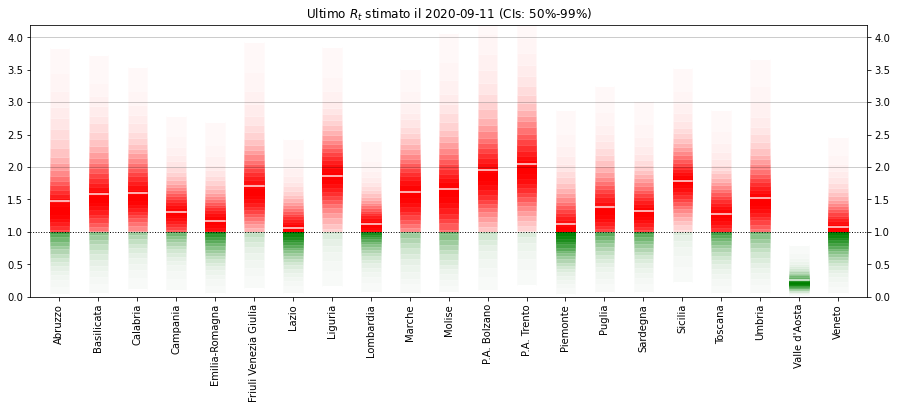

In [18]:
fig, ax = plt.subplots(figsize=(15,5))

for r, region in enumerate(countries):
    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r,:,-1], lowers[r,:,-1])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax.fill_between([r*2,r*2+1], 1, 12, color="red", zorder=0)
        ax.fill_between([r*2,r*2+1], 0, 1, color="green", zorder=0)
        ax.fill_between(np.linspace(r*2,r*2+1,10), np.zeros(10), lower, color="w", alpha=alpha)
        ax.fill_between(np.linspace(r*2,r*2+1,10), upper, np.ones(10)*12, color="w", alpha=alpha)
    ax.plot(np.linspace(r*2,r*2+1,10), np.ones(10)*means[r][-1], color="w", alpha=.9, zorder=100)

ax.axhline(1, c="k", ls=":", lw=1)
ax.hlines(np.arange(2, 12, 1), -1, countries.size*2+1, lw=1, alpha=.2)
ax.set_ylim(0, ymax)
ax.set_xlim(-1, countries.size*2)
ax.set_xticks(np.arange(.5, countries.size*2+.5, 2))
ax.set_xticklabels(countries.values, rotation=90)
ax.yaxis.set_ticks_position('both')
ax.tick_params(labelright=True)
ax.set_title(f"Ultimo $R_t$ stimato il {days[-1].date()} (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")
fig.set_facecolor('w'); plt.show();

***

# Test di Previsione

In [19]:
modelStringItalyPred = f"""
model {{
    ###################################
    # Rt estimation
    ###################################
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {{
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }}
    
    ###################################
    # Predictions
    ###################################
    # New cases precision prior
    y_tau ~ dgamma( 1 , 1 )
    
    for ( t in U:(T-1)) {{
        R_pred[t] <- sum(R[(t-P):t]) / P
        y_pred[t,1] <- y[t]
        y_pred_hi[t,1] <- y[t]
        y_pred_lo[t,1] <- y[t]
        PP[t,1] <- PPobs[t]
        PP_lo[t,1] <- PPobs[t]
        PP_hi[t,1] <- PPobs[t]

        for ( p in 2:P ) {{
            R_pred_hi[t,p] <- R_pred[t] + {epsilon} * (p-1) / (P-1)
            R_pred_lo[t,p] <- R_pred[t] - {epsilon} * (p-1) / (P-1)
        
            # most likely scenario
            y_prior[t,p] ~ dnorm( y_pred[t,(p-1)] , y_tau )  T(0,)
            lambda_pred[t,p] <- y_prior[t,p] * exp( gamma * ( R_pred[t] - 1 ) )
            y_pred[t,p] ~ dpois( lambda_pred[t,p] )
            PP[t,p] <- y_pred[t,p] / tests[t] * 100

            # worst scenario
            y_prior_hi[t,p] ~ dnorm( y_pred_hi[t,(p-1)] , y_tau )  T(0,)
            lambda_pred_hi[t,p] <- y_prior_hi[t,p] * exp( gamma * ( R_pred_hi[t,p] - 1 ) )
            y_pred_hi[t,p] ~ dpois( lambda_pred_hi[t,p] )
            PP_hi[t,p] <- y_pred_hi[t,p] / tests[t] * 100

            # best scenario
            y_prior_lo[t,p] ~ dnorm( y_pred_lo[t,(p-1)] , y_tau )  T(0,)
            lambda_pred_lo[t,p] <- y_prior_lo[t,p] * exp( gamma * ( R_pred_lo[t,p] - 1 ) )
            y_pred_lo[t,p] ~ dpois( lambda_pred_lo[t,p] )
            PP_lo[t,p] <- y_pred_lo[t,p] / tests[t] * 100
        }}
    }}
}}
"""

In [20]:
prediction = 7
U = ((it['casi_testati']>0).values).nonzero()[0][0]

model_data_italy_pred = {
    "y": pos_it_smt.values,
    "k": pos_it_smt.values,
    "T": days.size,
    "P": prediction+1,
    "tests": tst_it_smt.values,
    "PPobs": PP_smt,
    "U": U
}

In [21]:
print("Starting MCMC...")

jags_model_italy_pred = pyjags.Model(
    code=modelStringItalyPred, 
    data=model_data_italy_pred,
    chains=4, 
    adapt=adapt,
    progress_bar=True
)

jags_posteriors_italy_pred = jags_model_italy_pred.sample(
    warmup + sample, vars=["R", "sigma_R", "y_pred", "y_pred_hi", "y_pred_lo", "PP", "PP_hi", "PP_lo"]
)

clear_output()

_ = """with open("posterior_samples_italy_pred.pkl", "wb") as f:
    pickle.dump(jags_posteriors_italy_pred, f)"""

## Nuovi casi

Ultimi 8 giorni.

Legenda:

- linea nera tratteggiata: nuovi casi osservati
- linea blu intera: nuovi casi smussati
- area blu: previsione nuovi casi più probabile HPDI 90%
- area verde: previsione nuovi casi miglior scenario HPDI 99%
- area arancio: previsione nuovi casi peggior scenario HPDI 99%

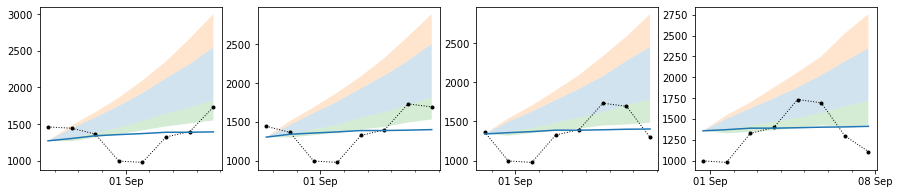

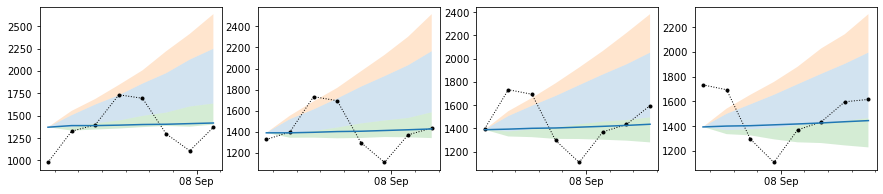

In [22]:
rows = 4

for i, u in enumerate(np.arange(days.size-prediction*2-1, (days.size-prediction), 1)):
    if not i % rows:
        fig, ax = plt.subplots(1, rows, figsize=(15, 3))
        
    pyjags_data_italy_pred = az.from_pyjags(
        {'y_pred': jags_posteriors_italy_pred['y_pred'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    pyjags_data_italy_pred_hi = az.from_pyjags(
        {'y_pred': jags_posteriors_italy_pred['y_pred_hi'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    pyjags_data_italy_pred_lo = az.from_pyjags(
        {'y_pred': jags_posteriors_italy_pred['y_pred_lo'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    smry = az.summary(pyjags_data_italy_pred, hdi_prob=.9, kind="stats")
    smry_hi = az.summary(pyjags_data_italy_pred_hi, hdi_prob=.99, kind="stats")
    smry_lo = az.summary(pyjags_data_italy_pred_lo, hdi_prob=.99, kind="stats")
    
    ax[i%rows].plot(
        it.iloc[u:(u+prediction+1)]['nuovi_positivi'],
        'ok:', lw=1, ms=3
    )
    ax[i%rows].plot(
        it.index[u:(u+prediction+1)],
        pos_it_smt[u:(u+prediction+1)]
    )
    ax[i%rows].fill_between(
        it.index[u:(u+prediction+1)],
        smry['hdi_5%'], smry['hdi_95%'],
        alpha=.2
    )
    ax[i%rows].fill_between(
        it.index[u:(u+prediction+1)],
        smry['hdi_95%'], smry_hi['hdi_99.5%'],
        alpha=.2
    )
    ax[i%rows].fill_between(
        it.index[u:(u+prediction+1)],
        smry_lo['hdi_0.5%'], smry['hdi_5%'],
        alpha=.2
    )
    ax[i%rows].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[i%rows].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax[i%rows].xaxis.set_minor_locator(mdates.DayLocator())
    
    if i % rows == rows - 1:
        plt.show()
        plt.close(fig="all")

## Tasso di Positività

Ultimi 8 giorni.

Legenda:

- linea nera tratteggiata: Tasso di Positività osservato
- linea blu intera: Tasso di Positività smussato
- area blu: previsione Tasso di Positività più probabile HPDI 90%
- area verde: previsione Tasso di Positività miglior scenario HPDI 99%
- area arancio: previsione Tasso di Positività peggior scenario HPDI 99%

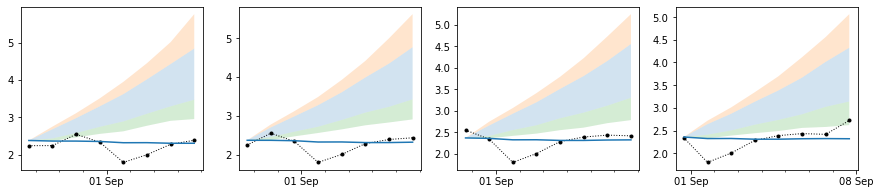

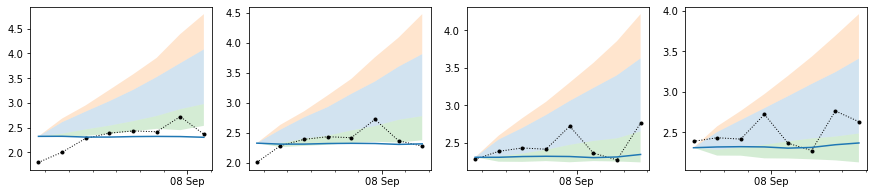

In [23]:
rows = 4

for i, u in enumerate(np.arange(days.size-prediction*2-2, (days.size-prediction-1), 1)):
    if not i % rows:
        fig, ax = plt.subplots(1, rows, figsize=(15, 3))
        
    pyjags_data_italy_pred = az.from_pyjags(
        {'PP': jags_posteriors_italy_pred['PP'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    pyjags_data_italy_pred_hi = az.from_pyjags(
        {'PP': jags_posteriors_italy_pred['PP_hi'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    pyjags_data_italy_pred_lo = az.from_pyjags(
        {'PP': jags_posteriors_italy_pred['PP_lo'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    smry = az.summary(pyjags_data_italy_pred, hdi_prob=.9, kind="stats")
    smry_hi = az.summary(pyjags_data_italy_pred_hi, hdi_prob=.99, kind="stats")
    smry_lo = az.summary(pyjags_data_italy_pred_lo, hdi_prob=.99, kind="stats")
    
    ax[i%rows].plot(
        PP_raw.iloc[u:(u+prediction+1)],
        'ok:', lw=1, ms=3
    )
    ax[i%rows].plot(
        PP_raw.index[u:(u+prediction+1)],
        PP_smt[u:(u+prediction+1)]
    )
    ax[i%rows].fill_between(
        PP_raw.index[u:(u+prediction+1)],
        smry['hdi_5%'], smry['hdi_95%'],
        alpha=.2
    )
    ax[i%rows].fill_between(
        PP_raw.index[u:(u+prediction+1)],
        smry['hdi_95%'], smry_hi['hdi_99.5%'],
        alpha=.2
    )
    ax[i%rows].fill_between(
        PP_raw.index[u:(u+prediction+1)],
        smry_lo['hdi_0.5%'], smry['hdi_5%'],
        alpha=.2
    )
    ax[i%rows].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[i%rows].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax[i%rows].xaxis.set_minor_locator(mdates.DayLocator())
    
    if i % rows == rows - 1:
        plt.show()
        plt.close(fig="all")

***

In [24]:
end = dt.datetime.now()
print(f"END: {end}, Completed in {end - start}")

END: 2020-09-11 17:48:51.487485, Completed in 0:34:50.814532
